In [1]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy

from data_util import (
    load_subjects,
    load_subject_data,
    load_data,
    euclidean_alignment,
    label_alignment,
    np_standardize,
)

from fbcsp import FBCSP

In [53]:
# %%time
# fmt: off

# subjects = [
#     'K299', 'K300', 
#     'K309', 'K310', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K318', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K300', 'K309', 'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K327', 
    'K328', 'K329', 'K332', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K354', 'K355', 
    'K358', 'K359', 'K360', 'K361', 'K362', 
    'K364', 'K366', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
    # 'ALS01_t1', 'ALS01_t2',
    # 'ALS02_t1', 'ALS02_t2',
]

# subjects = [
#     'K300', 'K309', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K320', 'K321', 
#     'K322', 'K324', 'K325', 'K327', 'K328', 
#     'K329', 'K332', 'K335', 'K336', 'K337', 
#     'K338', 'K339', 'K354', 'K355', 'K358', 
#     'K359', 'K361', 'K362', 'K366', 'K368', 
#     'K369', 'K370', 'K371', 'K374', 'K375',
# ]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
#     "há miệng",
]

events = [
    "Thinking",
#     "Thinking and Acting",
    # "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]
# channels = [
#    # "F7", "F3", "Fz", "F4", "F8",
#    "FC5", "FC1", "FC2", "FC6",
#    "C3", "Cz", "C4",
#    "CP5", "CP1", "CP2", "CP6",
#    # "P7", "P3", "Pz", "P4", "P8",
# ]

label_mapping={
#     "nâng tay trái_Thinking": "mi",
#     "nâng tay phải_Thinking": "mi",
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
#     "nâng tay trái_Thinking": "nâng tay",
#     "nâng tay phải_Thinking": "nâng tay",
#     "nâng chân trái_Thinking": "mi",
#     "nâng chân phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
#     "gật đầu_Thinking": "mi",
#     "lắc đầu_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "nâng tay trái_Thinking and Acting": "other",
    # "nâng tay phải_Thinking and Acting": "other",
    # "nâng chân trái_Thinking and Acting": "other",
    # "nâng chân phải_Thinking and Acting": "other",
    # "gật đầu_Thinking and Acting": "other",
    # "lắc đầu_Thinking and Acting": "other",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.25  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

# ds = load_data(
#     "../data/vin/Official",  
#     subjects=subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=None, 
#     fmax=None, 
#     moving_standardize=False,
#     epoch_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

filt_ds = load_data(
    "../data/vin/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# for _ds in filt_ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = filt_ds.description
# fmt: on

using 32 channels


subject:  37%|███▋      | 37/101 [00:00<00:00, 215.47it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  84%|████████▍ | 85/101 [00:03<00:00, 20.69it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne

In [26]:
multi_filt_ds = list()
for fmin, fmax in [(i, i + 4) for i in range(8, 28, 2)]:
    _filt_ds = load_data(
        "../data/vin/Official",  
        subjects=subjects,
        scenarios=scenarios,
        events=events,
        channels=channels,
        label_mapping=label_mapping,
        minimal_trial_duration=minimal_trial_duration,
        window_duration=window_duration, 
        window_stride_duration=window_stride_duration, 
        start_offset=0,
        stop_offset=0,
        fmin=fmin, 
        fmax=fmax, 
        moving_standardize=False,
        epoch_standardize=False,
        resample=None,
        return_raw=False,
        return_preprocessed=False,
        preload=True,
    )
    
    for _ds in _filt_ds.datasets:
        _ds_info = _ds.description
        if _ds_info["subject"] == "K314":
            _ds_info["subject"] = "K314_t1"
        elif _ds_info["subject"] == "K324":
            _ds_info["subject"] = "K314_t2"
    
    multi_filt_ds.append(_filt_ds)

subject:   0%|          | 0/101 [00:00<?, ?it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:   2%|▏         | 2/101 [00:00<00:30,  3.30it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  80%|████████  | 81/101 [00:03<00:00, 27.27it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were 

In [28]:
# with open("../data/vin/multi_filt_ds_8-30Hz.pkl", mode="wb") as f:
#     pkl.dump(multi_filt_ds, f)

### single band 8-30Hz

In [34]:
train_trials = {
    # 'gật đầu': [0, 1],
    # 'lắc đầu': [0, 1],
    'nâng chân phải': [0, 1],
    'nâng chân trái': [0, 1],
    'nâng tay phải': [0, 1],
    'nâng tay trái': [0, 1],
    # 'rest': [0, 1, 2, 3],
}
valid_trials = {
    # 'gật đầu': [2],
    # 'lắc đầu': [2],
    'nâng chân phải': [2],
    'nâng chân trái': [2],
    'nâng tay phải': [2],
    'nâng tay trái': [2],
    # 'rest': [4, 5],
}

target_subject = "K314_t1"
test_subject = "K314_t2"

# for _ds in ds.datasets:
for _ds in filt_ds.datasets:
    _ds_info = _ds.description
    if _ds_info["subject"].startswith("ALS"):
        _ds_info["split"] = "ignore"
    elif _ds_info["subject"] == test_subject:
        _ds_info["split"] = "test"
    elif _ds_info["subject"] == target_subject:
        _ds_info["split"] = "valid"
        # if _ds_info["trial"] in valid_trials[_ds_info["label"]]:
        #     _ds_info["split"] = "valid"
        # else:
        #     _ds_info["split"] = "train"
    else:
        _ds_info["split"] = "train"
        
# ds0 = deepcopy(ds)
ds0 = deepcopy(filt_ds)
splitter = ds0.split("split")
train_ds = splitter["train"]
valid_ds = splitter["valid"]
test_ds = splitter["test"]

In [35]:
# aligned_ds = deepcopy(train_ds)

# label_alignment(train_ds, target_subject=target_subject, labeled_trials=train_trials)

euclidean_alignment(train_ds, target_subject=None, labeled_trials=None)
euclidean_alignment(valid_ds, target_subject=None, labeled_trials=None)
euclidean_alignment(test_ds, target_subject=None, labeled_trials=None)

# aligned_ds_8_30hz = deepcopy(ds_8_30hz)

# euclidean_alignment(aligned_ds_8_30hz, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 1/1 [00:00<00:00, 40.30it/s]


In [36]:
%%time
##################load data#######################
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
Xtest = list()
Ytest = list()
for _ds in train_ds.datasets:
    Xtrain.append(_ds.windows.get_data())
    Ytrain.extend(_ds.y)
for _ds in valid_ds.datasets:
    Xvalid.append(_ds.windows.get_data())
    Yvalid.extend(_ds.y)
for _ds in test_ds.datasets:
    Xtest.append(_ds.windows.get_data())
    Ytest.extend(_ds.y)
            
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)
Xtest = np.concatenate(Xtest, axis=0)
Ytest = np.array(Ytest, dtype=int)

print(f"train: {Xtrain.shape, np.bincount(Ytrain)}")
print(f"valid: {Xvalid.shape, np.bincount(Yvalid)}")
print(f" test: {Xtest.shape, np.bincount(Ytest)}")

###################train model###################

clf = make_pipeline(
    # FBCSP(
    #     filters=[(i, i + 4) for i in range(8, 28, 2)],
    #     filter_order=0,
    #     sfreq=128.0,
    #     n_components=8,
    #     # reg="ledoit_wolf",
    #     log=True,
    #     norm_trace=False,
    # ),
    mne.decoding.CSP(
        n_components=8,
        # reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ), 
    SVC(
        C=1.0,
        kernel="rbf",
        tol=1e-7,
        max_iter=30000,
        class_weight="balanced",
        random_state=42,
    ),
    # LinearDiscriminantAnalysis(
    #     solver="lsqr",
    #     shrinkage="auto",
    #     n_components=None,
    #     tol=1e-7,
    #     covariance_estimator=None,
    # ),
)

clf.fit(Xtrain, Ytrain)
    
##################evaluate model#######################
y_pred = clf.predict(Xvalid)
    
sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')

print("valid" + "#" * 10)
print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

y_pred = clf.predict(Xtest)
    
sub_acc = metrics.balanced_accuracy_score(Ytest, y_pred)
sub_f1 = metrics.f1_score(Ytest, y_pred, average='weighted')

print("test" + "#" * 10)
print(f"report:\n{metrics.classification_report(Ytest, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Ytest, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

train: ((9618, 11, 256), array([2391, 2426, 2385, 2416]))
valid: ((238, 11, 256), array([58, 58, 56, 66]))
 test: ((234, 11, 256), array([53, 56, 63, 62]))
valid##########
report:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        58
           1       0.43      0.67      0.53        58
           2       0.21      0.16      0.18        56
           3       0.70      0.53      0.60        66

    accuracy                           0.47       238
   macro avg       0.47      0.47      0.46       238
weighted avg       0.48      0.47      0.46       238

confusion matrix:
[[29 13 13  3]
 [ 6 39 10  3]
 [ 3 35  9  9]
 [18  3 10 35]]

accuracy:	0.4658577772801911
f1_weighted:	0.46298168063026457
test##########
report:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        53
           1       0.39      0.32      0.35        56
           2       0.53      0.63      0.58        63
   

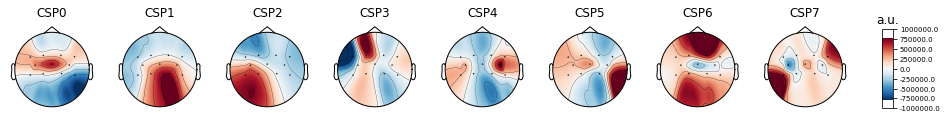

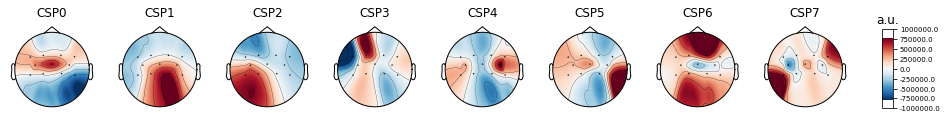

In [37]:
info = ds.datasets[0].windows.info

clf[0].plot_patterns(info)

In [54]:
train_ds = filt_ds.split("subject")["K314"]

Xtrain = list()
Ytrain = list()
for _ds in train_ds.datasets:
    Xtrain.append(_ds.windows.get_data())
    Ytrain.append(np.array(_ds.y, dtype=int))
    
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.concatenate(Ytrain, axis=0)

Xtrain.shape, Ytrain.shape

((357, 32, 256), (357,))

In [55]:
clf = make_pipeline(
    mne.decoding.CSP(
        n_components=8,
        # reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ), 
    # SVC(
    #     C=1.0,
    #     kernel="rbf",
    #     tol=1e-7,
    #     max_iter=30000,
    #     class_weight="balanced",
    #     random_state=42,
    # ),
    LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto",
        n_components=None,
        tol=1e-7,
        covariance_estimator=None,
    ),
)

clf.fit(X=Xtrain, y=Ytrain)
y_pred = clf.predict(Xtrain)

print(metrics.classification_report(y_true=Ytrain, y_pred=y_pred))
print(metrics.confusion_matrix(y_true=Ytrain, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83        60
           1       0.86      0.75      0.80        59
           2       1.00      0.97      0.98        58
           3       0.92      1.00      0.96        58
           4       0.92      0.84      0.88        56
           5       0.88      0.91      0.90        66

    accuracy                           0.89       357
   macro avg       0.89      0.89      0.89       357
weighted avg       0.89      0.89      0.89       357

[[53  7  0  0  0  0]
 [15 44  0  0  0  0]
 [ 0  0 56  2  0  0]
 [ 0  0  0 58  0  0]
 [ 0  0  0  1 47  8]
 [ 0  0  0  2  4 60]]


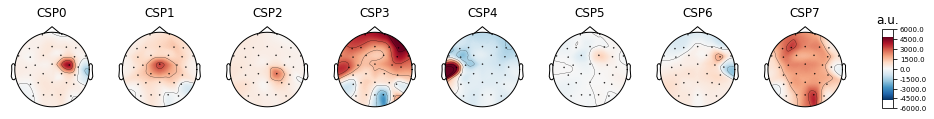

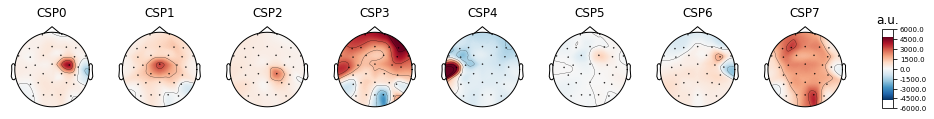

In [56]:
clf[0].plot_patterns(filt_ds.datasets[0].windows.info)

gật đầu


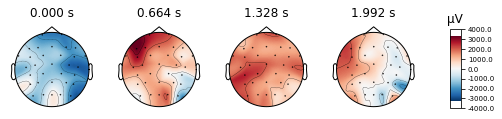

lắc đầu


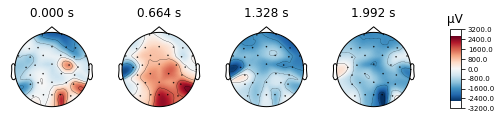

nâng chân phải


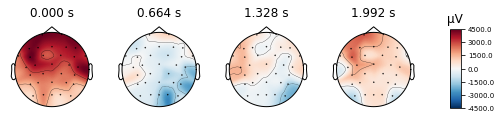

nâng chân trái


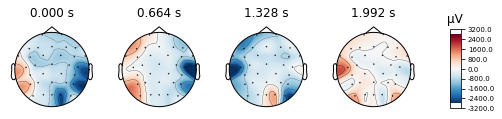

nâng tay phải


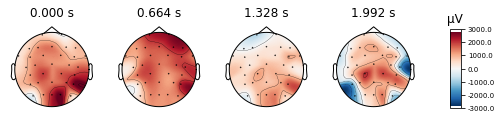

nâng tay trái


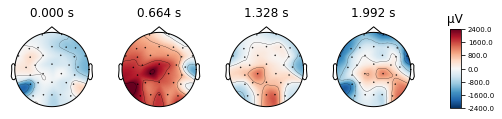

In [57]:
# ERD (mu) overs the contralateral hemisphere, ERS (beta) overs region ipsilateral hemisphere

for label in train_ds.datasets[0].windows.event_id.keys():
    print(label)
    epochs = mne.concatenate_epochs([_ds.windows for _ds in train_ds.datasets if _ds.description["label"] == label])
    # epochs.plot_psd_topomap()
    # evoked = mne.EvokedArray(clf[0].patterns, epochs.info)
    evoked = epochs.average()
    evoked.plot_topomap()

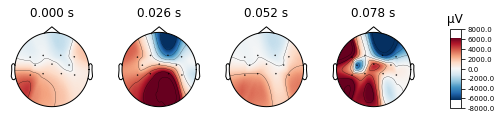

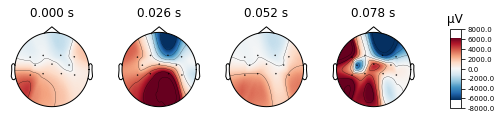

In [21]:
evoked.plot_topomap()

### multiple band from 8Hz to 30Hz

In [38]:
train_trials = {
    # 'gật đầu': [0, 1],
    # 'lắc đầu': [0, 1],
    'nâng chân phải': [0, 1],
    'nâng chân trái': [0, 1],
    'nâng tay phải': [0, 1],
    'nâng tay trái': [0, 1],
    # 'rest': [0, 1, 2, 3],
}
valid_trials = {
    # 'gật đầu': [2],
    # 'lắc đầu': [2],
    'nâng chân phải': [2],
    'nâng chân trái': [2],
    'nâng tay phải': [2],
    'nâng tay trái': [2],
    # 'rest': [4, 5],
}

target_subject = "K314_t1"
test_subject = "K314_t2"

train_ds = list()
valid_ds = list()
test_ds = list()
for _filt_ds in multi_filt_ds:
    for _ds in _filt_ds.datasets:
        _ds_info = _ds.description
        if _ds_info["subject"].startswith("ALS"):
            _ds_info["split"] = "ignore"
        elif _ds_info["subject"] == test_subject:
            _ds_info["split"] = "test"
        elif _ds_info["subject"] == target_subject:
            _ds_info["split"] = "valid"
            # if _ds_info["trial"] in valid_trials[_ds_info["label"]]:
            #     _ds_info["split"] = "valid"
            # else:
            #     _ds_info["split"] = "train"
        else:
            _ds_info["split"] = "train"
            
    splitter = _filt_ds.split("split")
    train_ds.append(splitter["train"])
    valid_ds.append(splitter["valid"])
    test_ds.append(splitter["test"])

In [40]:
for _ds in train_ds:
    euclidean_alignment(_ds, target_subject=None, labeled_trials=None)
for _ds in valid_ds:
    euclidean_alignment(_ds, target_subject=None, labeled_trials=None)
for _ds in test_ds:
    euclidean_alignment(_ds, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 1/1 [00:00<00:00, 53.72it/s]


In [42]:
%%time
##################load data#######################
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
Xtest = list()
Ytest = list()
for _filt_ds in train_ds:
    for _ds in _filt_ds.datasets:
        Xtrain.append(_ds.windows.get_data())
        Ytrain.append(np.array(_ds.y, dtype=int))
for _filt_ds in valid_ds:
    for _ds in _filt_ds.datasets:
        Xvalid.append(_ds.windows.get_data())
        Yvalid.append(np.array(_ds.y, dtype=int))
for _filt_ds in test_ds:
    for _ds in _filt_ds.datasets:
        Xtest.append(_ds.windows.get_data())
        Ytest.append(np.array(_ds.y, dtype=int))
            
Xtrain = np.concatenate(Xtrain, axis=0)  # [F*B,C,T]
Ytrain = np.array(Ytrain, dtype=int)  # [F*B,]
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)
Xtest = np.concatenate(Xtest, axis=0)
Ytest = np.array(Ytest, dtype=int)

_, c, t = Xtrain.shape
Xtrain = Xtrain.reshape((len(train_ds), -1, c, t))
Ytrain = Ytrain.reshape((len(train_ds), -1))[0]
Xvalid = Xvalid.reshape((len(valid_ds), -1, c, t))
Yvalid = Yvalid.reshape((len(valid_ds), -1))[0]
Xtest = Xtest.reshape((len(test_ds), -1, c, t))
Ytest = Ytest.reshape((len(test_ds), -1))[0]

print(f"train: {Xtrain.shape, np.bincount(Ytrain)}")
print(f"valid: {Xvalid.shape, np.bincount(Yvalid)}")
print(f" test: {Xtest.shape, np.bincount(Ytest)}")

###################train model###################

# filterband csp
fbcsp = [
    mne.decoding.CSP(
        n_components=8,
        # reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ) for _ in range(len(Xtrain))
]

x = list()
for i, csp in enumerate(fbcsp):
    xi = csp.fit_transform(X=Xtrain[i], y=Ytrain)  # [B,nc]
    x.append(xi)
    
x = np.stack(x).transpose((1, 0, 2)).reshape((len(Xtrain), -1))

# clf
clf = SVC(
    C=1.0,
    kernel="rbf",
    tol=1e-7,
    max_iter=30000,
    class_weight="balanced",
    random_state=42,
)
# clf = LinearDiscriminantAnalysis(
#     solver="lsqr",
#     shrinkage="auto",
#     n_components=None,
#     tol=1e-7,
#     covariance_estimator=None,
# )

clf.fit(X=x, y=Ytrain)
    
##################evaluate model#######################
x = list()
for i, csp in enumerate(fbcsp):
    xi = csp.transform(X=Xvalid[i])  # [B,nc]
    x.append(xi)
    
x = np.stack(x).transpose((1, 0, 2)).reshape((len(Xvalid), -1))
y_pred = clf.predict(x)
    
sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')

print("valid" + "#" * 10)
print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

x = list()
for i, csp in enumerate(fbcsp):
    xi = csp.transform(X=Xtest[i])  # [B,nc]
    x.append(xi)
    
x = np.stack(x).transpose((1, 0, 2)).reshape((len(Xtest), -1))
y_pred = clf.predict(x)
    
sub_acc = metrics.balanced_accuracy_score(Ytest, y_pred)
sub_f1 = metrics.f1_score(Ytest, y_pred, average='weighted')

print("test" + "#" * 10)
print(f"report:\n{metrics.classification_report(Ytest, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Ytest, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4580,) + inhomogeneous part.

In [173]:
epochs = aligned_ds_8_30hz.datasets[30].windows
print(aligned_ds_8_30hz.datasets[30].y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [174]:
evoked = mne.EvokedArray(clf[0].patterns_, epochs.info, tmin=epochs.tmin)

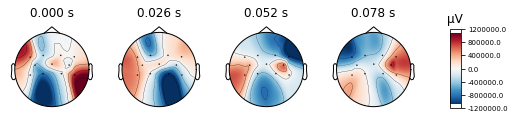

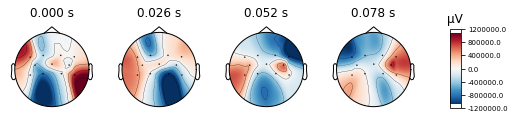

In [175]:
evoked.plot_topomap()

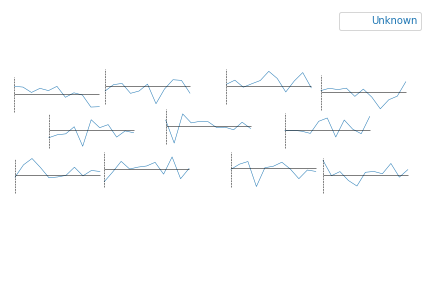

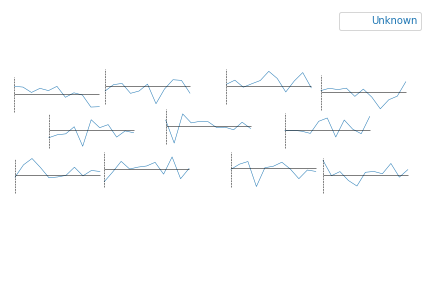

In [176]:
evoked.plot_topo()

In [209]:
lepochs = list()
repochs = list()
fepochs = list()
for _ds in ds_8_30hz.datasets:
    if _ds.description["subject"] == "K324":
        if _ds.description["label"] == "nâng tay trái":
            lepochs.append(_ds.windows)
        elif _ds.description["label"] == "nâng tay phải":
            repochs.append(_ds.windows)
        else:
            fepochs.append(_ds.windows)
        
lepochs = mne.concatenate_epochs(lepochs)
repochs = mne.concatenate_epochs(repochs)
# fepochs = mne.concatenate_epochs(fepochs)

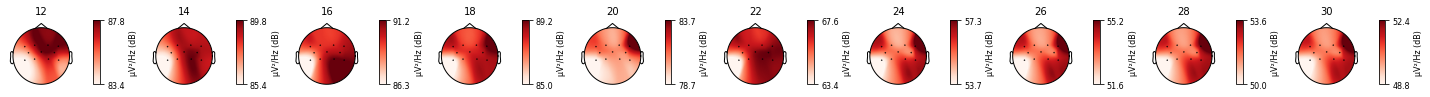

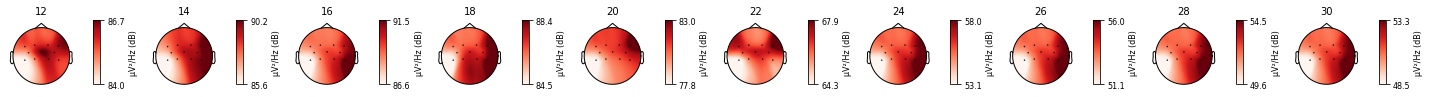

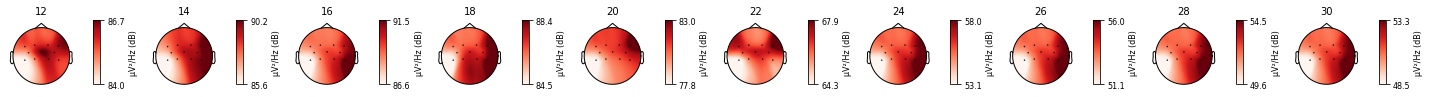

In [210]:
lepochs.plot_psd_topomap(bands=((i, i + 4) for i in range(8, 28, 2)))
repochs.plot_psd_topomap(bands=((i, i + 4) for i in range(8, 28, 2)))
# fepochs.plot_psd_topomap(bands=((i, i + 4) for i in range(8, 28, 2)))

In [ ]:
# (9618, 11, 256) [2391 2426 2385 2416] (238, 11, 256) [58 58 56 66]
# valid##########
# report:
#               precision    recall  f1-score   support

#            0       0.47      0.62      0.53        58
#            1       0.31      0.36      0.33        58
#            2       0.18      0.09      0.12        56
#            3       0.62      0.61      0.61        66

#     accuracy                           0.43       238
#    macro avg       0.39      0.42      0.40       238
# weighted avg       0.40      0.43      0.41       238

# confusion matrix:
# [[36  6  8  8]
#  [22 21 13  2]
#  [15 21  5 15]
#  [ 4 20  2 40]]

# accuracy:	0.4195262352589939
# f1_weighted:	0.40856586909572995
# test##########
# report:
#               precision    recall  f1-score   support

#            0       0.63      0.72      0.67        53
#            1       0.21      0.12      0.16        56
#            2       0.47      0.56      0.51        63
#            3       0.43      0.47      0.45        62

#     accuracy                           0.47       234
#    macro avg       0.44      0.47      0.45       234
# weighted avg       0.44      0.47      0.45       234

# confusion matrix:
# [[38 12  0  3]
#  [15  7 24 10]
#  [ 3  0 35 25]
#  [ 4 14 15 29]]

# accuracy:	0.4663196557787246
# f1_weighted:	0.4466698994756661
# CPU times: user 24.3 s, sys: 25 s, total: 49.3 s
# Wall time: 4.08 s

In [240]:
ds_info = aligned_ds_8_30hz.description
ds_info[ds_info["subject"] == "K324"]

subject        scenario     event           label  trial  split
169    K324   nâng tay trái  Thinking   nâng tay trái      0  train
170    K324   nâng tay trái  Thinking   nâng tay trái      1  train
171    K324   nâng tay trái  Thinking   nâng tay trái      2  train
172    K324   nâng tay phải  Thinking   nâng tay phải      0  train
173    K324   nâng tay phải  Thinking   nâng tay phải      1  train
174    K324   nâng tay phải  Thinking   nâng tay phải      2  train
175    K324  nâng chân trái  Thinking  nâng chân trái      0  train
176    K324  nâng chân trái  Thinking  nâng chân trái      1  train
177    K324  nâng chân trái  Thinking  nâng chân trái      2  train
178    K324  nâng chân phải  Thinking  nâng chân phải      0  train
179    K324  nâng chân phải  Thinking  nâng chân phải      1  train
180    K324  nâng chân phải  Thinking  nâng chân phải      2  train

In [222]:
ds.datasets[0].windows.event_id

{'nâng chân phải': 0,
 'nâng chân trái': 1,
 'nâng tay phải': 2,
 'nâng tay trái': 3}

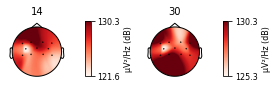

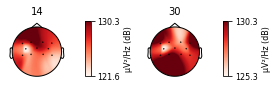

In [243]:
e = mne.concatenate_epochs([aligned_ds_8_30hz.datasets[i].windows for i in ds_info[(ds_info["subject"] == "K324") & (ds_info["label"] == "nâng tay trái")].index])
# print(aligned_ds_8_30hz.datasets[175].y[0])
e.plot_psd_topomap(bands=((8, 14), (14, 30)))

In [244]:
clf[0].transform(e.get_data()).mean(axis=0)

array([-0.0374087 , -0.01983993, -0.17061188, -0.14026447, -0.29884103,
        0.14443253,  0.1767513 ,  0.26508233])

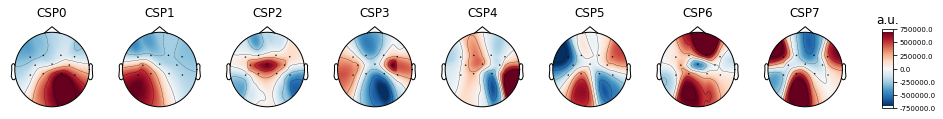

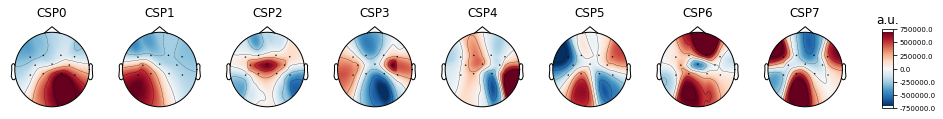

In [245]:
# (4900, 11, 256) [2449 2451] (148, 11, 256) [55 93]
# report:
#               precision    recall  f1-score   support

#            0       0.62      0.75      0.68        55
#            1       0.83      0.73      0.78        93

#     accuracy                           0.74       148
#    macro avg       0.73      0.74      0.73       148
# weighted avg       0.75      0.74      0.74       148

# confusion matrix:
# [[41 14]
#  [25 68]]

# accuracy:	0.7383186705767351
# f1_weighted:	0.7401825201825201
# CPU times: user 12.8 s, sys: 14.4 s, total: 27.2 s
# Wall time: 2.14 s

clf[0].plot_patterns(ds.datasets[0].windows.info)

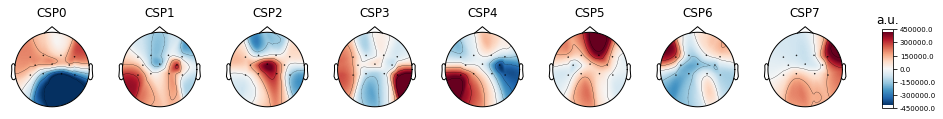

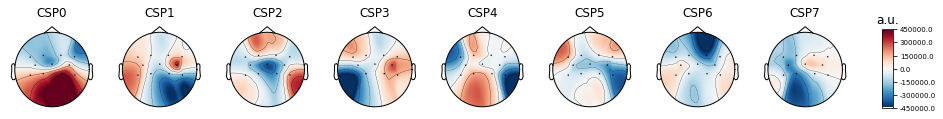

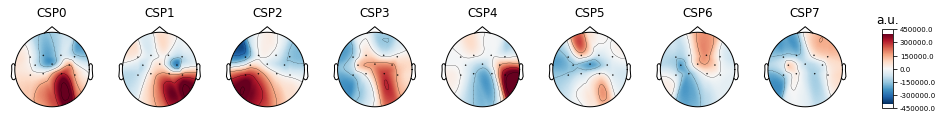

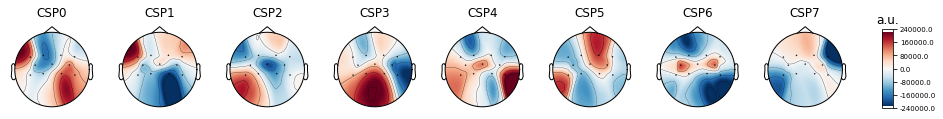

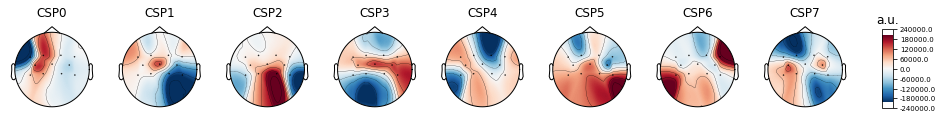

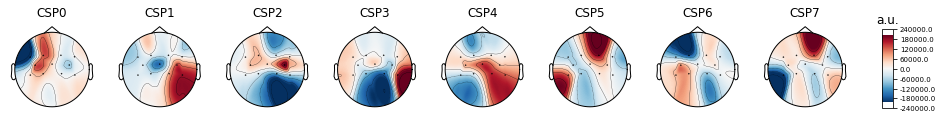

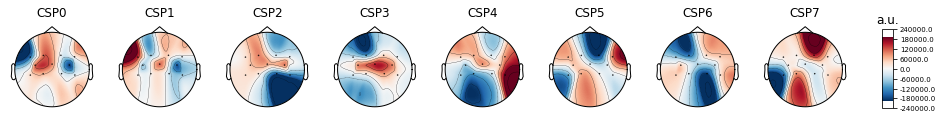

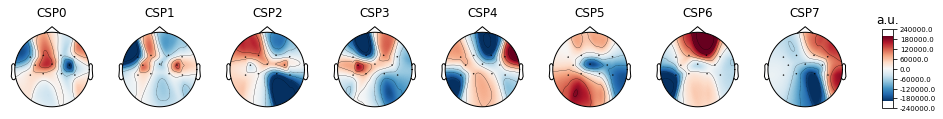

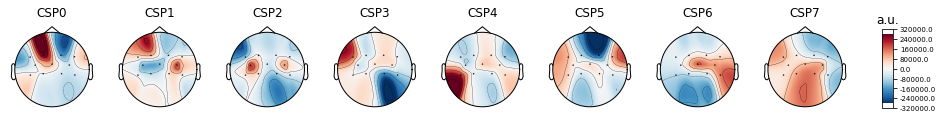

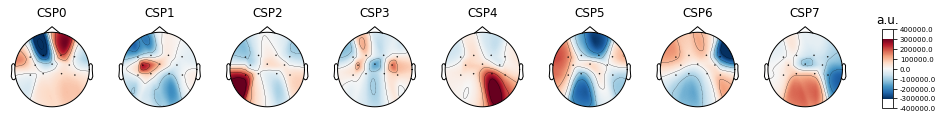

In [22]:
# (4900, 11, 256) [2449 2451] (148, 11, 256) [55 93]
# report:
#               precision    recall  f1-score   support

#            0       0.70      0.35      0.46        55
#            1       0.70      0.91      0.79        93

#     accuracy                           0.70       148
#    macro avg       0.70      0.63      0.63       148
# weighted avg       0.70      0.70      0.67       148

# confusion matrix:
# [[19 36]
#  [ 8 85]]

# accuracy:	0.6297165200391006
# f1_weighted:	0.6713939834523377
# CPU times: user 4min 32s, sys: 2min 10s, total: 6min 42s
# Wall time: 2min 48s

info = ds.datasets[0].windows.info
for csp in clf[0].filt_csp:
    csp.plot_patterns(info)

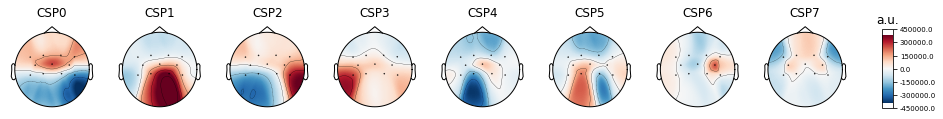

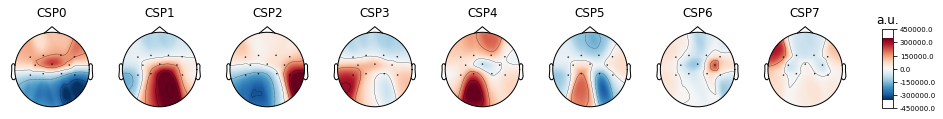

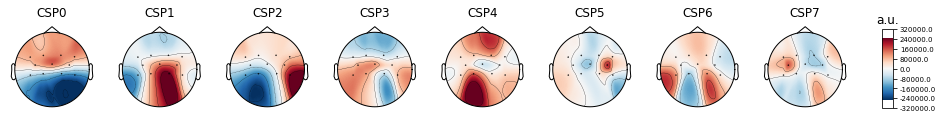

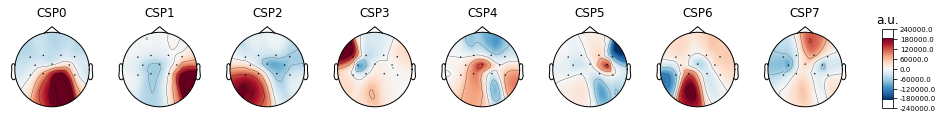

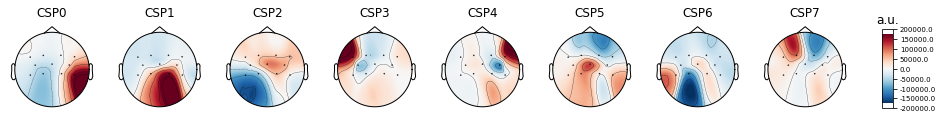

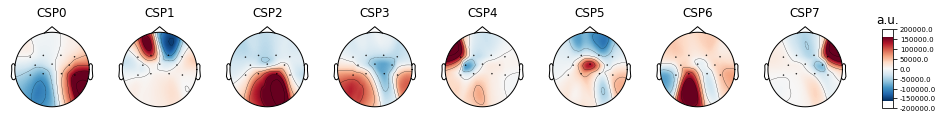

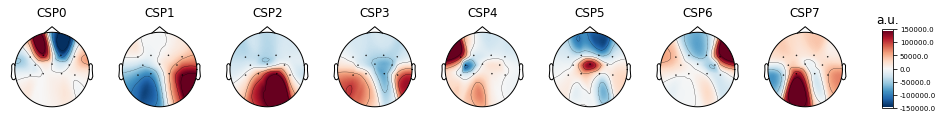

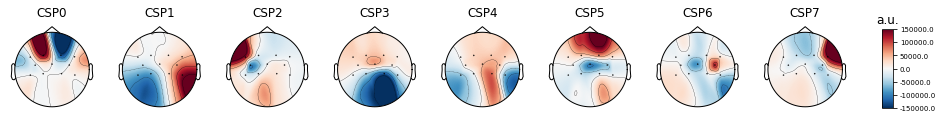

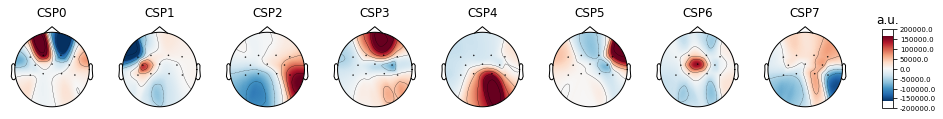

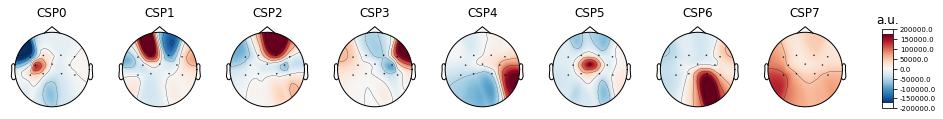

In [17]:
info = ds.datasets[0].windows.info
for csp in clf[0].filt_csp:
    csp.plot_patterns(info)

In [48]:
fb_ds = list()
for fmin, fmax in [(i, i + 4) for i in range(8, 28, 2)]:
    print(f"loading {fmin}-{fmax}Hz dataset...")

    fb_ds.append(load_data(
        "../data/vin/Official",  
        subjects=subjects,
        scenarios=scenarios,
        events=events,
        channels=channels,
        label_mapping=label_mapping,
        minimal_trial_duration=minimal_trial_duration,
        window_duration=window_duration, 
        window_stride_duration=window_stride_duration, 
        start_offset=0,
        stop_offset=0,
        fmin=fmin, 
        fmax=fmax, 
        moving_standardize=False,
        epoch_standardize=False,
        resample=None,
        return_raw=False,
        return_preprocessed=False,
        preload=True,
    ))

loading 8-12Hz dataset...


subject:  73%|███████▎  | 74/101 [00:02<00:01, 22.11it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  89%|████████▉ | 90/101 [00:03<00:00, 21.55it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.

loading 10-14Hz dataset...


subject:  83%|████████▎ | 84/101 [00:03<00:00, 25.90it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  86%|████████▌ | 87/101 [00:03<00:00, 20.72it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  89%|████████▉ | 90/101 [00:03<00:00, 19.52it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) 

loading 12-16Hz dataset...


subject:  83%|████████▎ | 84/101 [00:03<00:00, 22.61it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  86%|████████▌ | 87/101 [00:03<00:00, 15.85it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  89%|████████▉ | 90/101 [00:04<00:00, 15.08it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) 

loading 14-18Hz dataset...


subject:  77%|███████▋  | 78/101 [00:03<00:01, 21.05it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  85%|████████▌ | 86/101 [00:03<00:00, 19.73it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.

loading 16-20Hz dataset...


subject:  84%|████████▍ | 85/101 [00:02<00:00, 25.49it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, v

loading 18-22Hz dataset...


subject:  80%|████████  | 81/101 [00:02<00:00, 28.20it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  89%|████████▉ | 90/101 [00:03<00:00, 24.41it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.

loading 20-24Hz dataset...


subject:  70%|███████   | 71/101 [00:02<00:01, 26.89it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  85%|████████▌ | 86/101 [00:02<00:00, 28.39it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.

loading 22-26Hz dataset...


subject:  83%|████████▎ | 84/101 [00:02<00:00, 28.90it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, v

loading 24-28Hz dataset...


subject:  83%|████████▎ | 84/101 [00:02<00:00, 29.64it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, v

loading 26-30Hz dataset...


subject:  79%|███████▉  | 80/101 [00:02<00:00, 30.15it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  85%|████████▌ | 86/101 [00:02<00:00, 23.17it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  90%|█████████ | 91/101 [00:03<00:00, 22.12it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s)

In [3]:
# with open("../data/vin/40subjects_11channels_fb8-30-2.pkl", mode="wb") as f:
#     pkl.dump(fb_ds, f)

with open("../data/vin/40subjects_11channels_fb8-30-2.pkl", mode="rb") as f:
    aligned_fb_ds = pkl.load(f)

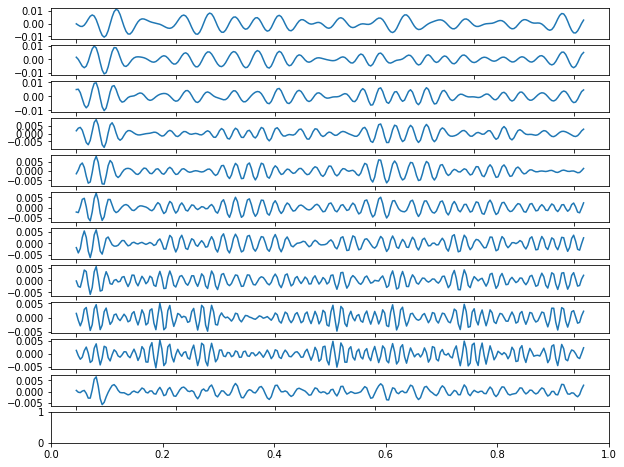

In [49]:
fig, axes = plt.subplots(nrows=len(fb_ds) + 2, ncols=1, figsize=(10, 8))

x0 = 0
for i, ds in enumerate(fb_ds):
    xi = ds.datasets[0].windows.get_data()[0, 0]
    x0 += xi

    axes[i].plot(range(len(xi)), xi)
    
x0 /= len(fb_ds)
axes[len(fb_ds)].plot(range(len(x0)), x0)

# xz = base_ds.datasets[0].windows.get_data()[0, 0]
# axes[len(fb_ds) + 1].plot(range(len(xz)), xz)

In [16]:
aligned_base_ds = deepcopy(base_ds)

euclidean_alignment(aligned_base_ds, target_subject=None, labeled_trials=None)

subject: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.83it/s]


In [50]:
# aligned_fb_ds = deepcopy(fb_ds)

for ds in fb_ds:
    euclidean_alignment(ds, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 40/40 [00:00<00:00, 51.75it/s]


In [5]:
for ds in aligned_fb_ds:
    _info = ds.datasets[0].windows.info
    print(_info["highpass"], _info["lowpass"])

8.0 12.0
10.0 14.0
12.0 16.0
14.0 18.0
16.0 20.0
18.0 22.0
20.0 24.0
22.0 26.0
24.0 28.0
26.0 30.0


In [52]:
%%time
target_subject = "K314"
test_subject = "K324"

##################load data#######################
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
Xtest = list()
Ytest = list()
for ds in fb_ds:
    for _ds in ds.datasets:
        _ds_info = _ds.description
        if _ds_info["subject"] == target_subject:
            Xvalid.append(_ds.windows.get_data())
            Yvalid.extend(_ds.y)
        elif _ds_info["subject"] == test_subject:
            Xtest.append(_ds.windows.get_data())
            Ytest.extend(_ds.y)
        else:
            Xtrain.append(_ds.windows.get_data())
            Ytrain.extend(_ds.y)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)
Xtest = np.concatenate(Xtest, axis=0)
Ytest = np.array(Ytest, dtype=int)
    
_, c, t = Xtrain.shape
Xtrain = Xtrain.reshape((-1, len(fb_ds), c, t)).transpose((1, 0, 2, 3))
Ytrain = Ytrain.reshape((-1, len(fb_ds))).transpose((1, 0))[0]
Xvalid = Xvalid.reshape((-1, len(fb_ds), c, t)).transpose((1, 0, 2, 3))
Yvalid = Yvalid.reshape((-1, len(fb_ds))).transpose((1, 0))[0]
Xtest = Xtest.reshape((-1, len(fb_ds), c, t)).transpose((1, 0, 2, 3))
Ytest = Ytest.reshape((-1, len(fb_ds))).transpose((1, 0))[0]

print(Xtrain.shape, np.bincount(Ytrain), Xvalid.shape, np.bincount(Yvalid), Xtest.shape, np.bincount(Ytest))

(10, 9618, 11, 256) [2388 2430 2380 2420] (10, 238, 11, 256) [58 58 56 66] (10, 234, 11, 256) [52 56 64 62]
CPU times: user 1.26 s, sys: 2.07 s, total: 3.33 s
Wall time: 3.34 s


In [54]:
%%time
# ################train model#######################

fb_csp = [
    mne.decoding.CSP(
        n_components=8,
#         reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ) for _ in range(len(Xtrain))
]

lda = LinearDiscriminantAnalysis(
    solver="lsqr",
    shrinkage="auto",
    n_components=None,
    tol=1e-7,
    covariance_estimator=None,
)

# train
print("training")
x = list()
for i, csp in enumerate(fb_csp):
    x.append(csp.fit_transform(X=Xtrain[i], y=Ytrain))
    
x = np.stack(x).transpose((1, 2, 0)).reshape((Xtrain.shape[1], -1))
# print(x.shape)

lda.fit(X=x, y=Ytrain)

# for csp in fb_csp:
#     csp.plot_patterns(info)

# predict
print("predicting")
x = list()
for i, csp in enumerate(fb_csp):
    x.append(csp.transform(X=Xtest[i]))
    
x = np.stack(x).transpose((1, 2, 0)).reshape((Xtest.shape[1], -1))
# print(x.shape)

y_pred = lda.predict(x)

# print(y_pred)
    
# # clf = make_pipeline(
# #     Covariances("cov"),
# #     TSclassifier(
# #         metric="riemann",
# #         clf=SVC(
# #             C=1.0,
# #             kernel="rbf",
# #             tol=1e-7,
# #             max_iter=30000,
# #             class_weight="balanced",
# #             random_state=42,
# #         ),
# #         # clf=LinearDiscriminantAnalysis(
# #         #     solver="lsqr",
# #         #     shrinkage="auto",
# #         #     n_components=None,
# #         #     tol=1e-7,
# #         #     covariance_estimator=None,
# #         # ),
# #     ),
# # )

# clf = make_pipeline(
#     FBCSP(
# #         filters=[(8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32)],
#         filters=[(8, 12), (12, 32)],
#         filter_order=0,
#         sfreq=128.0,
#         n_components=8,
#         # reg="ledoit_wolf",
#         log=True,
#         norm_trace=False,
#     ),
#     mne.decoding.CSP(
#         n_components=8,
# #         reg="ledoit_wolf",
#         log=True,
#         norm_trace=False,
#     ), 
    # SVC(
    #     C=1.0,
    #     kernel="rbf",
    #     tol=1e-7,
    #     max_iter=30000,
    #     class_weight="balanced",
    #     random_state=42,
    # ),
#     LinearDiscriminantAnalysis(
#         solver="lsqr",
#         shrinkage="auto",
#         n_components=None,
#         tol=1e-7,
#         covariance_estimator=None,
#     ),
# )

# clf.fit(Xtrain, Ytrain)
    
##################evaluate model#######################
# y_pred = clf.predict(Xvalid)
    
sub_acc = metrics.balanced_accuracy_score(Ytest, y_pred)
sub_f1 = metrics.f1_score(Ytest, y_pred, average='weighted')
    
print(f"report:\n{metrics.classification_report(Ytest, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Ytest, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

training
predicting
report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        52
           1       0.46      0.41      0.43        56
           2       0.63      0.64      0.64        64
           3       0.56      0.56      0.56        62

    accuracy                           0.61       234
   macro avg       0.60      0.61      0.61       234
weighted avg       0.60      0.61      0.60       234

confusion matrix:
[[43  6  0  3]
 [ 5 23 21  7]
 [ 0  5 41 18]
 [ 8 16  3 35]]

accuracy:	0.6106946229174052
f1_weighted:	0.6030404476175037
CPU times: user 4min 23s, sys: 4min 5s, total: 8min 28s
Wall time: 36.5 s


In [ ]:
# training
# predicting
# report:
#               precision    recall  f1-score   support

#            0       0.42      0.75      0.54        40
#            1       0.42      0.38      0.40        50
#            2       0.62      0.30      0.41        50
#            3       0.37      0.55      0.44        60
#            4       0.32      0.26      0.29        50
#            5       0.73      0.58      0.65       100

#     accuracy                           0.48       350
#    macro avg       0.48      0.47      0.45       350
# weighted avg       0.52      0.48      0.48       350

# confusion matrix:
# [[30  9  0  0  0  1]
#  [30 19  1  0  0  0]
#  [11 11 15 11  2  0]
#  [ 1  6  6 33  7  7]
#  [ 0  0  1 23 13 13]
#  [ 0  0  1 22 19 58]]

# accuracy:	0.47000000000000003
# f1_weighted:	0.47818916133243633
# CPU times: user 1min 4s, sys: 49.6 s, total: 1min 54s
# Wall time: 41.7 s

In [58]:
Xtest.shape

(10, 234, 11, 256)

In [64]:
x1 = fb_csp[0].patterns_[np.newaxis] @ Xtest[0]
x1.shape

(234, 11, 256)

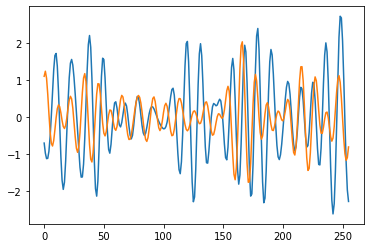

In [66]:
plt.plot(range(256), Xtest[0, 0, 0])
plt.plot(range(256), x1[0, 0])

In [86]:
fb_ds[1].datasets[0].windows

<Epochs |  19 events (all good), 0 - 1.99219 sec, baseline off, ~448 kB, data loaded, with metadata,
 'nâng chân phải': 0
 'nâng chân trái': 0
 'nâng tay phải': 0
 'nâng tay trái': 19>

3


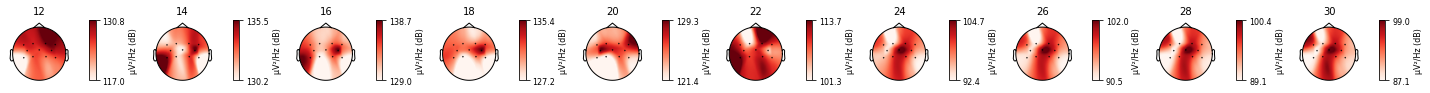

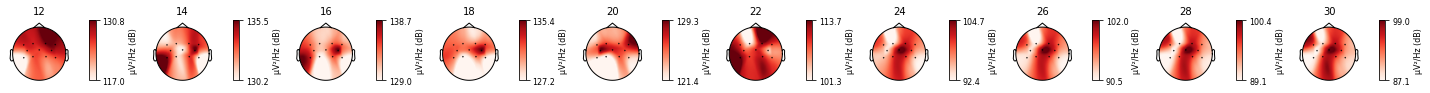

In [87]:
e = fb_ds[1].datasets[0].windows
print(fb_ds[1].datasets[0].y[0])
e[0].plot_psd_topomap(bands=((i, i + 4) for i in range(8, 28, 2)))

In [88]:
for csp in fb_csp:
    print(csp.transform(e.get_data())[0])

[-0.17998403 -0.72292112  0.33486647 -0.03498926 -0.24378076 -0.531928
  0.0540043   0.86092019]
[-0.37293042 -0.70085189  0.39269975 -0.0439933  -0.01886985  0.79919079
  0.48960659 -0.62389568]
[-0.22863318 -0.70790201  0.3310821   0.05527524 -0.17951117  0.4437286
  0.07490513 -0.08059414]
[-0.38252096 -0.70205207  0.40254971  0.02461827  0.02422938  0.00731068
  0.44521985 -0.26029442]
[-3.23124214e-01 -7.20516889e-01  3.85733207e-01  1.84788599e-02
  3.75577190e-01  2.28918276e-04  4.27760613e-01 -3.66122177e-01]
[-0.29357819 -0.71146357  0.40450637 -0.05110827  0.3010686  -0.03282021
  0.44681378 -0.50123307]
[-0.24688135 -0.73477708  0.39392355 -0.07884192  0.28778033 -0.04843403
  0.42390787 -0.45343025]
[-0.24472322 -0.73949304  0.39709513 -0.07225308 -0.04167306  0.2421385
  0.44741357 -0.37848218]
[-0.22066647 -0.74067943  0.41470733 -0.09272878 -0.04039253  0.12602036
  0.44546855 -0.32379455]
[-0.33826864 -0.74259657  0.45139177 -0.04803119 -0.02660353  0.0167147
  0.49028

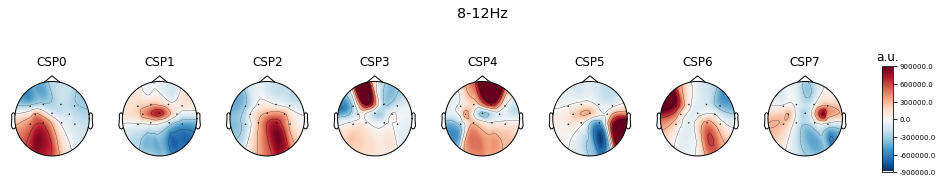

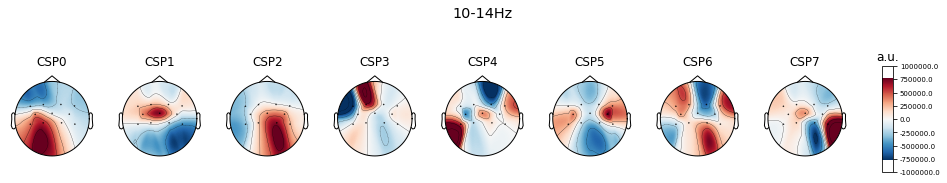

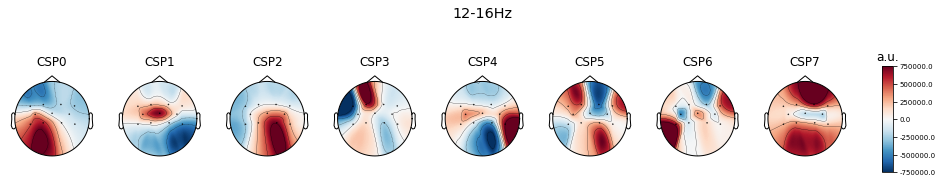

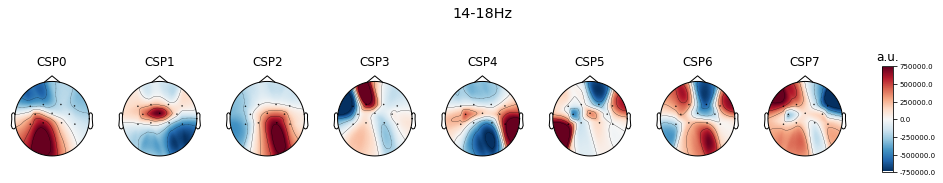

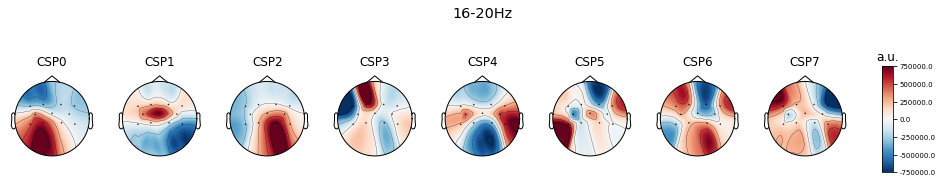

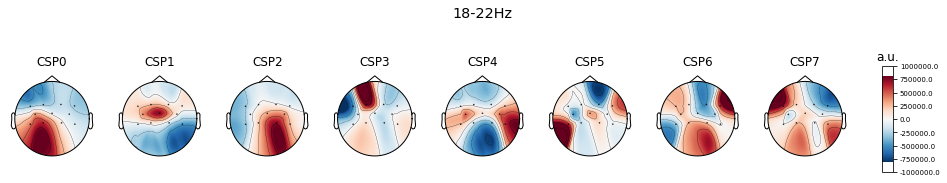

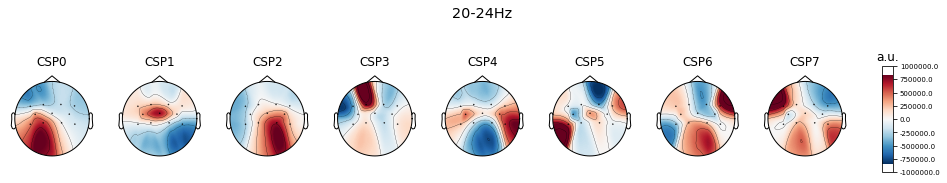

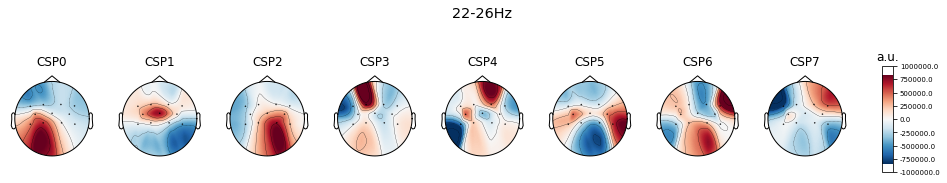

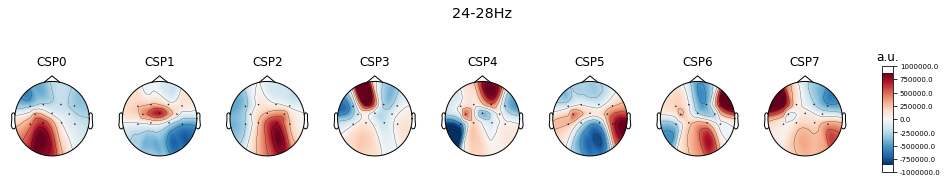

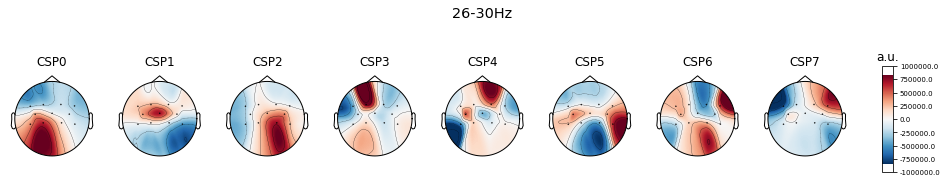

In [57]:
info = fb_ds[0].dataseget_datawindows.info
for (lfreq, hfreq), csp in zip([(i, i + 4) for i in range(8, 28, 2)], fb_csp):
    csp.plot_filters(info, title=f"{lfreq}-{hfreq}Hz")

In [63]:
la_aligned_base_ds = deepcopy(base_ds)

label_alignment(la_aligned_base_ds, target_subject="K355", labeled_trials={"nâng tay trái": [0], 
                                                                           "nâng tay phải": [0], 
                                                                           "nâng chân trái": [0], 
                                                                           "nâng chân phải": [0], 
                                                                           "gật đầu": [0], 
                                                                           "lắc đầu": [0]})

subject: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.99it/s]


In [68]:
subject = "K355"

Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
for ds in la_aligned_base_ds.datasets:
    ds_info = ds.description
    if ds_info["subject"] == subject and ds_info["trial"] > 0:
        Xvalid.append(ds.windows.get_data())
        Yvalid.extend(ds.y)
    else:
        Xtrain.append(ds.windows.get_data())
        Ytrain.extend(ds.y)
# for ds in la_aligned_base_ds.datasets:
#     Xtrain.append(ds.windows.get_data())
#     Ytrain.extend(ds.y)
    
# for ds in base_ds.datasets:
#     ds_info = ds.description
#     if ds_info["subject"] == subject:
#         Xvalid.append(ds.windows.get_data())
#         Yvalid.extend(ds.y)
        
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

print(np.bincount(Ytrain), np.bincount(Yvalid))

[2408 2435 2465 2508 2462 2511] [32 32 37 32 42 33]


In [69]:
clf = make_pipeline(
    mne.decoding.CSP(
        n_components=8,
#         reg="ledoit_wolf",
        log=True,
        norm_trace=True,
    ), 
#     SVC(
#         C=1.0,
#         kernel="rbf",
#         tol=1e-7,
#         max_iter=30000,
#         class_weight="balanced",
#         random_state=42,
#     ),
    LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto",
        n_components=None,
        tol=1e-7,
        covariance_estimator=None,
    ),
)

clf.fit(Xtrain, Ytrain)

y_pred = clf.predict(Xvalid)
    
sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    
print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

report:
              precision    recall  f1-score   support

           0       0.28      0.31      0.29        32
           1       1.00      0.19      0.32        32
           2       0.63      1.00      0.77        37
           3       1.00      0.28      0.44        32
           4       0.47      1.00      0.64        42
           5       1.00      0.24      0.39        33

    accuracy                           0.54       208
   macro avg       0.73      0.50      0.47       208
weighted avg       0.71      0.54      0.49       208

confusion matrix:
[[10  0 22  0  0  0]
 [26  6  0  0  0  0]
 [ 0  0 37  0  0  0]
 [ 0  0  0  9 23  0]
 [ 0  0  0  0 42  0]
 [ 0  0  0  0 25  8]]

accuracy:	0.5039457070707071
f1_weighted:	0.4889036691955568


In [48]:
i = 30
print(Ytrain[i])
clf[0].transform(Xtrain[i:i+1])

4


array([[-8.45812064, -6.43737691, -7.47567195, -7.23540244, -7.25983796,
        -7.4729101 , -7.21986895, -6.93725946]])

In [27]:
info = base_ds.datasets[0].windows.info

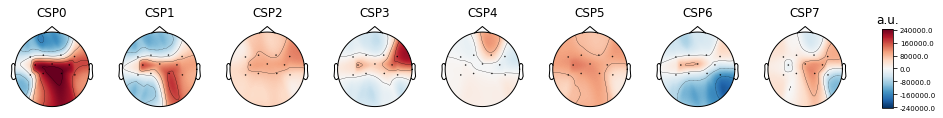

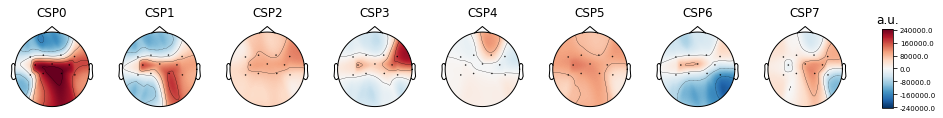

In [49]:
clf[0].plot_patterns(info)

In [72]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
for ds in base_ds.datasets:
    ds_info = ds.description
    if ds_info["subject"] == subject:
        Xvalid.append(ds.windows.get_data())
        Yvalid.extend(ds.y)
    else:
        Xtrain.append(ds.windows.get_data())
        Ytrain.extend(ds.y)
        
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

In [73]:
clf = make_pipeline(
    mne.decoding.CSP(
        n_components=8,
#         reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ), 
#     SVC(
#         C=1.0,
#         kernel="rbf",
#         tol=1e-7,
#         max_iter=30000,
#         class_weight="balanced",
#         random_state=42,
#     ),
    LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto",
        n_components=None,
        tol=1e-7,
        covariance_estimator=None,
    ),
)

clf.fit(Xtrain, Ytrain)

y_pred = clf.predict(Xvalid)
    
sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    
print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
print()
print(f"accuracy:\t{sub_acc}")
print(f"f1_weighted:\t{sub_f1}")

report:
              precision    recall  f1-score   support

           0       0.59      0.41      0.49        63
           1       0.54      0.71      0.62        62

    accuracy                           0.56       125
   macro avg       0.57      0.56      0.55       125
weighted avg       0.57      0.56      0.55       125

confusion matrix:
[[26 37]
 [18 44]]

accuracy:	0.5611879160266258
f1_weighted:	0.5501653486700215


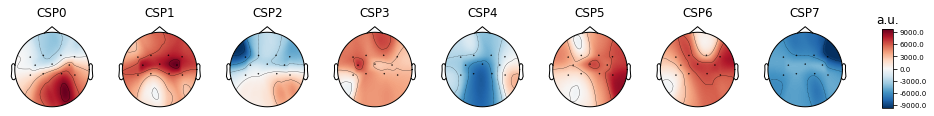

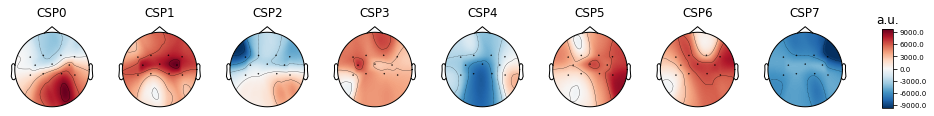

In [67]:
clf[0].plot_patterns(info)

In [64]:
aligned_filt_ds = deepcopy(filt_ds)

euclidean_alignment(aligned_filt_ds, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 40/40 [00:00<00:00, 44.06it/s]


In [58]:
len(list(filt_ds.description["subject"].unique()))

35

In [69]:
acc = list()
f1 = list()

for subject in subjects:
    Xtrain = list()
    Ytrain = list()
    Xvalid = list()
    Yvalid = list()
    for ds in filt_ds.datasets:
        ds_info = ds.description
        if ds_info["subject"] == subject:
            Xvalid.append(ds.windows.get_data())
            Yvalid.extend(ds.y)
        else:
            Xtrain.append(ds.windows.get_data())
            Ytrain.extend(ds.y)

    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xvalid = np.concatenate(Xvalid, axis=0)
    Yvalid = np.array(Yvalid, dtype=int)
    
    # clf = make_pipeline(
    #     Covariances("cov"),
    #     TSclassifier(
    #         metric="euclid",
    #         clf=LinearDiscriminantAnalysis(
    #             solver="lsqr",
    #             shrinkage="auto",
    #             n_components=None,
    #             tol=1e-7,
    #             covariance_estimator=None,
    #         ),
    #     ),
    # )
    
    clf = make_pipeline(
        mne.decoding.CSP(
            n_components=8,
    #         reg="ledoit_wolf",
            log=True,
            norm_trace=False,
        ), 
    #     SVC(
    #         C=1.0,
    #         kernel="rbf",
    #         tol=1e-7,
    #         max_iter=30000,
    #         class_weight="balanced",
    #         random_state=42,
    #     ),
        LinearDiscriminantAnalysis(
            solver="lsqr",
            shrinkage="auto",
            n_components=None,
            tol=1e-7,
            covariance_estimator=None,
        ),
    )

    clf.fit(Xtrain, Ytrain)

    y_pred = clf.predict(Xvalid)

    sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
    sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    acc.append(sub_acc)
    f1.append(sub_f1)

    print(f"subject: {subject}")
    print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
    print()
    print(f"accuracy:\t{sub_acc}")
    print(f"f1_weighted:\t{sub_f1}")
    print("#" * 10)

subject: K300
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        55
           3       0.37      1.00      0.54        93

    accuracy                           0.37       254
   macro avg       0.09      0.25      0.13       254
weighted avg       0.13      0.37      0.20       254

confusion matrix:
[[ 0  0  0 47]
 [ 0  0  0 59]
 [ 0  0  0 55]
 [ 0  0  0 93]]

accuracy:	0.25
f1_weighted:	0.1962604098118859
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K309
report:
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        59
           1       0.14      0.04      0.06        51
           2       0.00      0.00      0.00        58
           3       1.00      0.14      0.25        56

    accuracy                           0.31       224
   macro avg       0.36      0.30      0.19       224
weighted avg       0.36      0.31      0.20       224

confusion matrix:
[[59  0  0  0]
 [49  2  0  0]
 [58  0  0  0]
 [36 12  0  8]]

accuracy:	0.29551820728291317
f1_weighted:	0.1955928171445413
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K311
report:
              precision    recall  f1-score   support

           0       0.21      0.58      0.31        69
           1       0.14      0.15      0.15        53
           2       0.85      0.15      0.26        73
           3       0.00      0.00      0.00        65

    accuracy                           0.23       260
   macro avg       0.30      0.22      0.18       260
weighted avg       0.32      0.23      0.18       260

confusion matrix:
[[40 27  2  0]
 [45  8  0  0]
 [48 14 11  0]
 [57  8  0  0]]

accuracy:	0.22033461816520017
f1_weighted:	0.1834471185633976
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K312
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.00      0.00      0.00        60
           2       0.20      0.64      0.30        73
           3       0.59      0.42      0.49        90

    accuracy                           0.28       303
   macro avg       0.20      0.27      0.20       303
weighted avg       0.22      0.28      0.22       303

confusion matrix:
[[ 0  0 80  0]
 [ 0  0 60  0]
 [ 0  0 47 26]
 [ 0  0 52 38]]

accuracy:	0.2665144596651446
f1_weighted:	0.21917219194446916
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K313
report:
              precision    recall  f1-score   support

           0       0.93      0.36      0.52        74
           1       0.00      0.00      0.00        72
           2       0.50      0.03      0.07        86
           3       0.26      0.96      0.41        72

    accuracy                           0.33       304
   macro avg       0.42      0.34      0.25       304
weighted avg       0.43      0.33      0.24       304

confusion matrix:
[[27  5  0 42]
 [ 2  0  0 70]
 [ 0  0  3 83]
 [ 0  0  3 69]]

accuracy:	0.3395204797821077
f1_weighted:	0.24334289713308177
##########
subject: K314
report:
              precision    recall  f1-score   support

           0       0.29      0.17      0.22        58
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        56
           3       0.47      0.86      0.61        66

    accuracy                           0.28       238
   macro avg       0.19      0.26      0.2

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K316
report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43        71
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00        64

    accuracy                           0.27       259
   macro avg       0.07      0.25      0.11       259
weighted avg       0.08      0.27      0.12       259

confusion matrix:
[[71  0  0  0]
 [59  0  0  0]
 [65  0  0  0]
 [64  0  0  0]]

accuracy:	0.25
f1_weighted:	0.11795951795951795
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K320
report:
              precision    recall  f1-score   support

           0       0.63      0.43      0.51        56
           1       0.30      0.43      0.35        49
           2       0.17      0.02      0.04        51
           3       0.23      0.43      0.30        49

    accuracy                           0.33       205
   macro avg       0.33      0.33      0.30       205
weighted avg       0.34      0.33      0.30       205

confusion matrix:
[[24 21  4  7]
 [ 8 21  1 19]
 [ 5  1  1 44]
 [ 1 27  0 21]]

accuracy:	0.32633053221288516
f1_weighted:	0.30428944396156293
##########
subject: K321
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.00      0.00      0.00        60
           2       0.17      0.42      0.24        55
           3       0.07      0.11      0.09        54

    accuracy                           0.13       225
   macro avg       0.06      0.13      0.

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K322
report:
              precision    recall  f1-score   support

           0       0.25      0.76      0.37        51
           1       0.56      0.10      0.16        52
           2       1.00      0.08      0.14        52
           3       0.34      0.23      0.28        52

    accuracy                           0.29       207
   macro avg       0.54      0.29      0.24       207
weighted avg       0.54      0.29      0.24       207

confusion matrix:
[[39  4  0  8]
 [33  5  0 14]
 [47  0  4  1]
 [40  0  0 12]]

accuracy:	0.2921380090497738
f1_weighted:	0.2378784846452652
##########
subject: K323
report:
              precision    recall  f1-score   support

           0       0.24      1.00      0.39        49
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00        54

    accuracy                           0.24       203
   macro avg       0.06      0.25      0.10

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K324
report:
              precision    recall  f1-score   support

           0       0.07      0.21      0.11        53
           1       0.10      0.14      0.12        56
           2       0.00      0.00      0.00        63
           3       0.00      0.00      0.00        62

    accuracy                           0.08       234
   macro avg       0.04      0.09      0.06       234
weighted avg       0.04      0.08      0.05       234

confusion matrix:
[[11 42  0  0]
 [47  8  0  1]
 [61  0  0  2]
 [34 28  0  0]]

accuracy:	0.0876010781671159
f1_weighted:	0.05276393734588199
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K325
report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38        56
           1       0.00      0.00      0.00        82
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        50

    accuracy                           0.23       239
   macro avg       0.06      0.25      0.09       239
weighted avg       0.05      0.23      0.09       239

confusion matrix:
[[56  0  0  0]
 [82  0  0  0]
 [51  0  0  0]
 [50  0  0  0]]

accuracy:	0.25
f1_weighted:	0.08895822991277214
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K327
report:
              precision    recall  f1-score   support

           0       0.48      0.13      0.21        82
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        57
           3       0.26      1.00      0.41        60

    accuracy                           0.27       265
   macro avg       0.18      0.28      0.16       265
weighted avg       0.21      0.27      0.16       265

confusion matrix:
[[11 11  0 60]
 [ 8  0  0 58]
 [ 4  0  0 53]
 [ 0  0  0 60]]

accuracy:	0.2835365853658537
f1_weighted:	0.15820083178184713
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K328
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       1.00      0.24      0.39        67
           2       0.47      0.30      0.37        63
           3       0.34      0.96      0.51        71

    accuracy                           0.41       254
   macro avg       0.45      0.37      0.32       254
weighted avg       0.48      0.41      0.33       254

confusion matrix:
[[ 0  0  3 50]
 [ 0 16 15 36]
 [ 0  0 19 44]
 [ 0  0  3 68]]

accuracy:	0.37453493765244866
f1_weighted:	0.3345273800333697
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K329
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00        51
           2       0.17      0.04      0.06        54
           3       0.27      1.00      0.42        55

    accuracy                           0.26       217
   macro avg       0.11      0.26      0.12       217
weighted avg       0.11      0.26      0.12       217

confusion matrix:
[[ 0  0  7 50]
 [ 0  0  3 48]
 [ 0  0  2 52]
 [ 0  0  0 55]]

accuracy:	0.25925925925925924
f1_weighted:	0.12231317070026748
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K332
report:
              precision    recall  f1-score   support

           0       0.26      0.98      0.41        55
           1       0.40      0.06      0.11        63
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        51

    accuracy                           0.26       220
   macro avg       0.16      0.26      0.13       220
weighted avg       0.18      0.26      0.13       220

confusion matrix:
[[54  1  0  0]
 [59  4  0  0]
 [50  1  0  0]
 [47  4  0  0]]

accuracy:	0.2613275613275613
f1_weighted:	0.13326910876665335
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K335
report:
              precision    recall  f1-score   support

           0       0.27      1.00      0.43        70
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        76

    accuracy                           0.26       274
   macro avg       0.07      0.25      0.11       274
weighted avg       0.07      0.26      0.11       274

confusion matrix:
[[70  0  0  0]
 [67  0  0  0]
 [61  0  0  0]
 [61  8  7  0]]

accuracy:	0.25
f1_weighted:	0.10871253300201895
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K336
report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64        75
           1       0.33      0.75      0.46        72
           2       0.00      0.00      0.00        72
           3       0.39      0.22      0.29        67

    accuracy                           0.42       286
   macro avg       0.33      0.41      0.35       286
weighted avg       0.33      0.42      0.35       286

confusion matrix:
[[51 24  0  0]
 [12 54  0  6]
 [21 34  0 17]
 [ 1 51  0 15]]

accuracy:	0.4134701492537314
f1_weighted:	0.3498067092481986
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K337
report:
              precision    recall  f1-score   support

           0       0.22      0.03      0.05        66
           1       0.18      0.31      0.23        68
           2       0.12      0.15      0.13        72
           3       0.53      0.46      0.49        72

    accuracy                           0.24       278
   macro avg       0.26      0.24      0.23       278
weighted avg       0.27      0.24      0.23       278

confusion matrix:
[[ 2 34 30  0]
 [ 0 21 44  3]
 [ 1 34 11 26]
 [ 6 27  6 33]]

accuracy:	0.23755941770647654
f1_weighted:	0.2310151694555464
##########
subject: K338
report:
              precision    recall  f1-score   support

           0       0.43      0.61      0.50        70
           1       0.56      0.28      0.37       101
           2       0.40      0.03      0.05        70
           3       0.40      0.95      0.56        62

    accuracy                           0.44       303
   macro avg       0.45      0.47      0.3

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K354
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.24      1.00      0.39        54
           2       0.00      0.00      0.00        61
           3       0.50      0.05      0.09        64

    accuracy                           0.25       231
   macro avg       0.18      0.26      0.12       231
weighted avg       0.19      0.25      0.11       231

confusion matrix:
[[ 0 49  0  3]
 [ 0 54  0  0]
 [ 0 61  0  0]
 [ 0 61  0  3]]

accuracy:	0.26171875
f1_weighted:	0.11423783589682206
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K355
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.56      0.09      0.16        55
           2       0.00      0.00      0.00        62
           3       0.23      0.92      0.36        53

    accuracy                           0.24       225
   macro avg       0.20      0.25      0.13       225
weighted avg       0.19      0.24      0.12       225

confusion matrix:
[[ 0  0  0 55]
 [ 0  5  0 50]
 [ 0  0  0 62]
 [ 0  4  0 49]]

accuracy:	0.2538593481989708
f1_weighted:	0.12401022304832714
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K358
report:
              precision    recall  f1-score   support

           0       0.87      0.25      0.39        51
           1       0.42      0.26      0.32        57
           2       0.50      0.04      0.07        52
           3       0.35      0.98      0.51        57

    accuracy                           0.40       217
   macro avg       0.53      0.38      0.32       217
weighted avg       0.52      0.40      0.33       217

confusion matrix:
[[13 10  0 28]
 [ 0 15  2 40]
 [ 2 10  2 38]
 [ 0  1  0 56]]

accuracy:	0.3847443835833928
f1_weighted:	0.32876947700873366
##########
subject: K359
report:
              precision    recall  f1-score   support

           0       0.41      0.25      0.31        52
           1       0.00      0.00      0.00        53
           2       0.32      1.00      0.49        58
           3       1.00      0.08      0.14        53

    accuracy                           0.35       216
   macro avg       0.43      0.33      0.2

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K360
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.35      0.87      0.50        76
           2       0.00      0.00      0.00        74
           3       0.41      0.56      0.47        66

    accuracy                           0.37       280
   macro avg       0.19      0.36      0.24       280
weighted avg       0.19      0.37      0.25       280

confusion matrix:
[[ 0 63  0  1]
 [ 0 66  0 10]
 [ 0 32  0 42]
 [ 0 29  0 37]]

accuracy:	0.3572567783094099
f1_weighted:	0.2465070643642072
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K361
report:
              precision    recall  f1-score   support

           0       0.86      0.09      0.17        65
           1       0.21      0.14      0.17        71
           2       0.31      0.06      0.10        65
           3       0.26      0.79      0.39        63

    accuracy                           0.27       264
   macro avg       0.41      0.27      0.21       264
weighted avg       0.40      0.27      0.20       264

confusion matrix:
[[ 6 12  6 41]
 [ 1 10  0 60]
 [ 0 16  4 45]
 [ 0 10  3 50]]

accuracy:	0.2720855044798707
f1_weighted:	0.20362536906654552
##########
subject: K362
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.27      0.67      0.39        75
           2       0.17      0.04      0.07        67
           3       0.09      0.09      0.09        66

    accuracy                           0.22       273
   macro avg       0.13      0.20      0.1

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K366
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.16      0.34      0.22        61
           2       0.00      0.00      0.00        61
           3       0.26      0.38      0.31        76

    accuracy                           0.18       271
   macro avg       0.11      0.18      0.13       271
weighted avg       0.11      0.18      0.14       271

confusion matrix:
[[ 0 34 13 26]
 [ 7 21 10 23]
 [ 0 27  0 34]
 [ 0 47  0 29]]

accuracy:	0.18146031061259707
f1_weighted:	0.1362768230145907
##########
subject: K368
report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29        67
           1       0.03      0.04      0.04        76
           2       0.30      0.59      0.39        71
           3       1.00      0.03      0.05        74

    accuracy                           0.22       288
   macro avg       0.42      0.23      0.1

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K370
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.30      0.44      0.35        64
           2       0.00      0.00      0.00        62
           3       0.29      0.62      0.40        55

    accuracy                           0.25       250
   macro avg       0.15      0.26      0.19       250
weighted avg       0.14      0.25      0.18       250

confusion matrix:
[[ 0 30 28 11]
 [ 0 28 11 25]
 [ 0 15  0 47]
 [ 0 21  0 34]]

accuracy:	0.26392045454545454
f1_weighted:	0.17771092140123637
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K371
report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.24      1.00      0.39        63
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        60

    accuracy                           0.24       262
   macro avg       0.06      0.25      0.10       262
weighted avg       0.06      0.24      0.09       262

confusion matrix:
[[ 0 69  0  0]
 [ 0 63  0  0]
 [ 0 70  0  0]
 [ 0 60  0  0]]

accuracy:	0.25
f1_weighted:	0.09322372284204346
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K372
report:
              precision    recall  f1-score   support

           0       0.24      1.00      0.39        58
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        63
           3       1.00      0.02      0.03        60

    accuracy                           0.24       242
   macro avg       0.31      0.25      0.11       242
weighted avg       0.31      0.24      0.10       242

confusion matrix:
[[58  0  0  0]
 [61  0  0  0]
 [63  0  0  0]
 [59  0  0  1]]

accuracy:	0.25416666666666665
f1_weighted:	0.10111109651056518
##########


/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K373
report:
              precision    recall  f1-score   support

           0       0.15      0.34      0.21        64
           1       0.22      0.27      0.24        64
           2       0.11      0.02      0.03        53
           3       0.00      0.00      0.00        59

    accuracy                           0.17       240
   macro avg       0.12      0.16      0.12       240
weighted avg       0.12      0.17      0.13       240

confusion matrix:
[[22 35  3  4]
 [40 17  3  4]
 [37 15  1  0]
 [47 10  2  0]]

accuracy:	0.15706073113207547
f1_weighted:	0.1272992722598076
##########
subject: K374
report:
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        65
           1       0.71      0.19      0.30        63
           2       0.29      0.10      0.15        67
           3       0.30      0.88      0.45        60

    accuracy                           0.36       255
   macro avg       0.45      0.37      0.3

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./4classes_csp_8-30Hz_CF&C&CP_nonEA.csv", sep="\t")
result

0.2732142534267045 0.18678094742223766


subject       acc        f1
0     K300  0.250000  0.196260
1     K309  0.295518  0.195593
2     K311  0.220335  0.183447
3     K312  0.266514  0.219172
4     K313  0.339520  0.243343
5     K314  0.259013  0.220565
6     K315  0.250000  0.103988
7     K316  0.250000  0.117960
8     K320  0.326331  0.304289
9     K321  0.132323  0.080236
10    K322  0.292138  0.237878
11    K323  0.250000  0.093870
12    K324  0.087601  0.052764
13    K325  0.250000  0.088958
14    K327  0.283537  0.158201
15    K328  0.374535  0.334527
16    K329  0.259259  0.122313
17    K332  0.261328  0.133269
18    K335  0.250000  0.108713
19    K336  0.413470  0.349807
20    K337  0.237559  0.231015
21    K338  0.467924  0.367656
22    K339  0.278457  0.211317
23    K354  0.261719  0.114238
24    K355  0.253859  0.124010
25    K358  0.384744  0.328769
26    K359  0.331368  0.239828
27    K360  0.357257  0.246507
28    K361  0.272086  0.203625
29    K362  0.200588  0.145045
30    K364  0.289855  0.164673
31    K366  0.181460  0.136277
32    K368  0.227945  0.187146
33    K369  0.321963  0.236670
34    K370  0.263920  0.177711
35    K371  0.250000  0.093224
36    K372  0.254167  0.101111
37    K373  0.157061  0.127299
38    K374  0.371495  0.318232
39    K375  0.253720  0.171731

In [51]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./4classes_csp_8-30Hz_CF&C&CP_nonEA.csv", sep="\t")
result

0.4242667207805927 0.4175232287331987


subject       acc        f1
0     K300  0.641915  0.662083
1     K309  0.484767  0.494044
2     K311  0.452018  0.471303
3     K312  0.541900  0.555922
4     K313  0.539602  0.538971
5     K314  0.476638  0.473005
6     K315  0.522980  0.488173
7     K316  0.410769  0.398370
8     K320  0.353104  0.344268
9     K321  0.184001  0.179786
10    K322  0.274038  0.252266
11    K323  0.443300  0.453186
12    K324  0.531821  0.503461
13    K325  0.512372  0.511319
14    K327  0.321072  0.328023
15    K328  0.520081  0.538332
16    K329  0.445121  0.443105
17    K332  0.465313  0.458352
18    K335  0.290844  0.302962
19    K336  0.531733  0.505807
20    K337  0.358623  0.354827
21    K338  0.541888  0.494267
22    K339  0.452580  0.455271
23    K354  0.432507  0.403939
24    K355  0.379869  0.367721
25    K358  0.576710  0.573240
26    K359  0.438933  0.431424
27    K360  0.548672  0.527295
28    K361  0.264980  0.209356
29    K362  0.214718  0.216187
30    K364  0.296477  0.289392
31    K366  0.501982  0.511634
32    K368  0.553539  0.554422
33    K369  0.407977  0.364978
34    K370  0.431557  0.415329
35    K371  0.119695  0.139460
36    K372  0.467640  0.463827
37    K373  0.266167  0.266993
38    K374  0.373276  0.372680
39    K375  0.399492  0.385951

<AxesSubplot:xlabel='subject'>

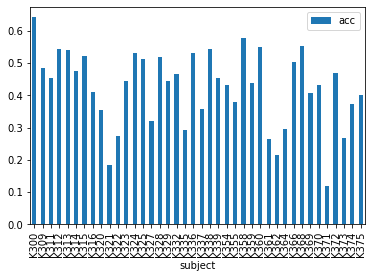

In [52]:
result.plot.bar(x="subject", y="acc")

<AxesSubplot:xlabel='subject'>

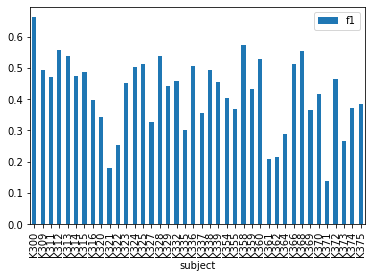

In [53]:
result.plot.bar(x="subject", y="f1")

In [112]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./4classes_csp_8-30Hz_CF&C&CP_EA.csv", sep="\t")
result

0.4198967763205128 0.413141652027986


subject       acc        f1
0     K300  0.629362  0.649043
1     K309  0.483867  0.492633
2     K311  0.474955  0.499031
3     K312  0.544930  0.558398
4     K313  0.518863  0.519499
5     K314  0.454102  0.445531
6     K315  0.530673  0.499789
7     K316  0.431486  0.418205
8     K320  0.382078  0.372647
9     K321  0.197607  0.187150
10    K322  0.288462  0.269985
11    K323  0.432151  0.441385
12    K324  0.493905  0.473353
13    K325  0.498762  0.492472
14    K327  0.315947  0.325128
15    K328  0.486419  0.501600
16    K329  0.449347  0.447683
17    K332  0.473249  0.466130
18    K335  0.272215  0.283358
19    K336  0.590622  0.576971
20    K337  0.302176  0.281231
21    K338  0.548570  0.502072
22    K339  0.440198  0.444668
23    K354  0.439610  0.415125
24    K355  0.362030  0.353581
25    K358  0.533579  0.524081
26    K359  0.443831  0.434999
27    K360  0.531958  0.505867
28    K361  0.261012  0.202176
29    K362  0.207988  0.208922
30    K364  0.295782  0.292217
31    K366  0.491034  0.498666
32    K368  0.526335  0.530498
33    K369  0.420137  0.376009
34    K370  0.419482  0.405909
35    K371  0.111801  0.132204
36    K372  0.455482  0.453186
37    K373  0.268932  0.270790
38    K374  0.376726  0.374695
39    K375  0.410206  0.398781

In [91]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./csp_8-32Hz_CF&C&CP_EA.csv", sep="\t")
result

0.624122032161404 0.6230386041785332


subject       acc        f1
0     K300  0.687879  0.687558
1     K309  0.431342  0.425454
2     K311  0.516754  0.518481
3     K312  0.559893  0.559448
4     K313  0.648417  0.646138
5     K314  0.623106  0.623560
6     K315  0.910390  0.911477
7     K316  0.356010  0.353088
8     K320  0.458583  0.457391
9     K321  0.367845  0.361062
10    K322  0.663462  0.662682
11    K323  0.758125  0.757419
12    K324  0.528674  0.524656
13    K325  0.692353  0.691374
14    K327  0.485965  0.486127
15    K328  0.761122  0.764077
16    K329  0.688047  0.688073
17    K332  0.666667  0.666153
18    K335  0.597606  0.591546
19    K336  0.834059  0.834481
20    K337  0.500000  0.498452
21    K338  0.830876  0.832870
22    K339  0.700061  0.700123
23    K354  0.567751  0.568000
24    K355  0.401096  0.400635
25    K358  0.754723  0.752002
26    K359  0.576936  0.576783
27    K360  0.736691  0.724263
28    K361  0.648718  0.648373
29    K362  0.511307  0.511278
30    K364  0.528679  0.528571
31    K366  0.770060  0.767122
32    K368  0.717834  0.717107
33    K369  0.877186  0.877074
34    K370  0.546921  0.547406
35    K371  0.464286  0.467994
36    K372  0.741270  0.739148
37    K373  0.559802  0.561552
38    K374  0.646766  0.645889
39    K375  0.647619  0.646657

In [89]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./csp_8-32Hz_CF&C&CP.csv", sep="\t")
result

0.5288119144492265 0.4449876505447465


subject       acc        f1
0     K300  0.500000  0.484973
1     K309  0.599138  0.587370
2     K311  0.500000  0.366028
3     K312  0.500000  0.392832
4     K313  0.432978  0.294727
5     K314  0.497024  0.462930
6     K315  0.500000  0.349800
7     K316  0.409495  0.392350
8     K320  0.428171  0.304000
9     K321  0.375926  0.375831
10    K322  0.682692  0.681957
11    K323  0.592593  0.492154
12    K324  0.561188  0.550165
13    K325  0.596863  0.559056
14    K327  0.517544  0.384677
15    K328  0.504918  0.497068
16    K329  0.500000  0.338443
17    K332  0.519608  0.375484
18    K335  0.513158  0.305597
19    K336  0.559701  0.470268
20    K337  0.833333  0.833205
21    K338  0.777419  0.772101
22    K339  0.621754  0.618365
23    K354  0.607454  0.558474
24    K355  0.521607  0.440828
25    K358  0.500000  0.359125
26    K359  0.525862  0.365760
27    K360  0.545455  0.454670
28    K361  0.500000  0.324689
29    K362  0.447761  0.313218
30    K364  0.514901  0.393965
31    K366  0.500000  0.395874
32    K368  0.511230  0.422543
33    K369  0.525289  0.478707
34    K370  0.452053  0.453392
35    K371  0.500000  0.376923
36    K372  0.500000  0.319872
37    K373  0.516949  0.342278
38    K374  0.473507  0.472800
39    K375  0.486905  0.437006

In [10]:
del fb_ds

NameError: name 'fb_ds' is not defined

In [7]:
acc = list()
f1 = list()

for subject in subjects:
    print(f"subject: {subject}")
    
    ##################load data#######################
    Xtrain = list()
    Ytrain = list()
    Xvalid = list()
    Yvalid = list()
    # for _ds in aligned_ds.datasets:
    #     _ds_info = _ds.description
    #     if _ds_info["subject"] == subject:
    #         Xvalid.append(_ds.windows.get_data())
    #         Yvalid.extend(_ds.y)
    #     else:
    #         Xtrain.append(_ds.windows.get_data())
    #         Ytrain.extend(_ds.y)
    for ds in aligned_fb_ds:
        for _ds in ds.datasets:  # single-band
            _ds_info = _ds.description
            if _ds_info["subject"] == subject:
                Xvalid.append(_ds.windows.get_data())
                Yvalid.extend(_ds.y)
            else:
                Xtrain.append(_ds.windows.get_data())
                Ytrain.extend(_ds.y)

    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xvalid = np.concatenate(Xvalid, axis=0)
    Yvalid = np.array(Yvalid, dtype=int)

    _, c, t = Xtrain.shape
    Xtrain = Xtrain.reshape((-1, len(aligned_fb_ds), c, t)).transpose((1, 0, 2, 3))
    Ytrain = Ytrain.reshape((-1, len(aligned_fb_ds))).transpose((1, 0))[0]
    Xvalid = Xvalid.reshape((-1, len(aligned_fb_ds), c, t)).transpose((1, 0, 2, 3))
    Yvalid = Yvalid.reshape((-1, len(aligned_fb_ds))).transpose((1, 0))[0]

#     print(Xtrain.shape, np.bincount(Ytrain), Xvalid.shape, np.bincount(Yvalid))
    
    # ################train model#######################

    fb_csp = [
        mne.decoding.CSP(
            n_components=8,
    #         reg="ledoit_wolf",
            log=True,
            norm_trace=False,
        ) for _ in range(len(Xtrain))
    ]

    lda = LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto",
        n_components=None,
        tol=1e-7,
        covariance_estimator=None,
    )

    # train
    x = list()
    for i, csp in enumerate(fb_csp):
        x.append(csp.fit_transform(X=Xtrain[i], y=Ytrain))

    x = np.stack(x).transpose((1, 2, 0)).reshape((Xtrain.shape[1], -1))
#     print(x.shape)

    lda.fit(X=x, y=Ytrain)

    # predict
    x = list()
    for i, csp in enumerate(fb_csp):
        x.append(csp.transform(X=Xvalid[i]))

    x = np.stack(x).transpose((1, 2, 0)).reshape((Xvalid.shape[1], -1))
#     print(x.shape)

    y_pred = lda.predict(x)

    ##################evaluate model#######################
    sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
    sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    acc.append(sub_acc)
    f1.append(sub_f1)

    print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
    print()
    print(f"accuracy:\t{sub_acc}")
    print(f"f1_weighted:\t{sub_f1}")
    print("#" * 10)

subject: K300
report:
              precision    recall  f1-score   support

           0       0.42      0.75      0.54        40
           1       0.42      0.38      0.40        50
           2       0.62      0.30      0.41        50
           3       0.37      0.55      0.44        60
           4       0.32      0.26      0.29        50
           5       0.73      0.58      0.65       100

    accuracy                           0.48       350
   macro avg       0.48      0.47      0.45       350
weighted avg       0.52      0.48      0.48       350

confusion matrix:
[[30  9  0  0  0  1]
 [30 19  1  0  0  0]
 [11 11 15 11  2  0]
 [ 1  6  6 33  7  7]
 [ 0  0  1 23 13 13]
 [ 0  0  1 22 19 58]]

accuracy:	0.47000000000000003
f1_weighted:	0.47818916133243633
##########
subject: K309
report:
              precision    recall  f1-score   support

           0       0.32      0.33      0.32        57
           1       0.44      0.32      0.37        56
           2       0.30      0

In [8]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./fbcsp_8-30-2Hz_CF&C&CP_loso.csv", sep="\t")
result

0.2815425336883073 0.2787781442657908


subject       acc        f1
0     K300  0.470000  0.478189
1     K309  0.374241  0.363240
2     K311  0.333135  0.310523
3     K312  0.329138  0.348677
4     K313  0.309980  0.303446
5     K314  0.348688  0.355182
6     K315  0.339974  0.338482
7     K316  0.277647  0.277526
8     K320  0.231745  0.233307
9     K321  0.232099  0.225808
10    K322  0.190420  0.190364
11    K323  0.282662  0.285734
12    K324  0.201479  0.193902
13    K325  0.247562  0.253862
14    K327  0.306334  0.315334
15    K328  0.319421  0.317576
16    K329  0.359589  0.347541
17    K332  0.144523  0.151722
18    K335  0.212996  0.216619
19    K336  0.271968  0.291780
20    K337  0.195030  0.201327
21    K338  0.246499  0.220325
22    K339  0.284566  0.292983
23    K354  0.258532  0.279141
24    K355  0.357703  0.356490
25    K358  0.320063  0.303107
26    K359  0.273746  0.265961
27    K360  0.329266  0.306395
28    K361  0.217226  0.217552
29    K362  0.286954  0.283981
30    K364  0.268314  0.264513
31    K366  0.347892  0.322448
32    K368  0.345222  0.335685
33    K369  0.312829  0.299474
34    K370  0.201064  0.200594
35    K371  0.133503  0.142209
36    K372  0.270079  0.269264
37    K373  0.167857  0.168861
38    K374  0.345312  0.336063
39    K375  0.316442  0.285939

In [97]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./fbcsp_4Hz_8-32Hz_CF&C&CP.csv", sep="\t")
result

0.524007445040202 0.48475441863646385


subject       acc        f1
0     K300  0.564421  0.608976
1     K309  0.551852  0.533882
2     K311  0.561869  0.491537
3     K312  0.547184  0.524570
4     K313  0.451873  0.395355
5     K314  0.545184  0.523293
6     K315  0.515152  0.381776
7     K316  0.439394  0.435741
8     K320  0.520000  0.507389
9     K321  0.505724  0.496889
10    K322  0.528846  0.504617
11    K323  0.515306  0.514746
12    K324  0.505376  0.488908
13    K325  0.499412  0.374081
14    K327  0.525000  0.511847
15    K328  0.530242  0.407072
16    K329  0.548316  0.524381
17    K332  0.596065  0.597767
18    K335  0.559642  0.527826
19    K336  0.563329  0.518763
20    K337  0.451389  0.451151
21    K338  0.696970  0.695221
22    K339  0.522059  0.521306
23    K354  0.559939  0.560056
24    K355  0.509434  0.396911
25    K358  0.538462  0.436144
26    K359  0.557505  0.496542
27    K360  0.493653  0.478135
28    K361  0.562500  0.533333
29    K362  0.508480  0.432447
30    K364  0.488971  0.411565
31    K366  0.508197  0.412104
32    K368  0.474210  0.472595
33    K369  0.455914  0.439053
34    K370  0.438596  0.429495
35    K371  0.478571  0.366263
36    K372  0.560714  0.501938
37    K373  0.568590  0.560228
38    K374  0.567910  0.549200
39    K375  0.444048  0.377072

In [95]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./fbcsp_4Hz_8-32Hz_CF&C&CP_EA.csv", sep="\t")
result

0.5925717563541854 0.5912490922810815


subject       acc        f1
0     K300  0.681442  0.660970
1     K309  0.520370  0.516541
2     K311  0.511995  0.513082
3     K312  0.538584  0.524043
4     K313  0.646156  0.646253
5     K314  0.591450  0.590825
6     K315  0.823377  0.823529
7     K316  0.419192  0.418255
8     K320  0.480000  0.478121
9     K321  0.220539  0.218869
10    K322  0.730769  0.730670
11    K323  0.836924  0.834951
12    K324  0.487839  0.487803
13    K325  0.524902  0.524659
14    K327  0.582456  0.580339
15    K328  0.728719  0.730981
16    K329  0.660269  0.660207
17    K332  0.615741  0.617389
18    K335  0.558348  0.562656
19    K336  0.668118  0.668824
20    K337  0.625000  0.623839
21    K338  0.795455  0.795349
22    K339  0.621732  0.621487
23    K354  0.576332  0.576000
24    K355  0.489957  0.486957
25    K358  0.760965  0.761468
26    K359  0.512671  0.513118
27    K360  0.502457  0.499490
28    K361  0.554688  0.553352
29    K362  0.541610  0.540834
30    K364  0.535539  0.535785
31    K366  0.694564  0.694317
32    K368  0.593357  0.593103
33    K369  0.762634  0.762247
34    K370  0.400000  0.399335
35    K371  0.488095  0.491581
36    K372  0.611905  0.606955
37    K373  0.489103  0.491357
38    K374  0.649378  0.644702
39    K375  0.670238  0.669721

In [144]:
acc = list()
f1 = list()

acc = list()
f1 = list()

for subject in subjects:
    Xtrain = list()
    Ytrain = list()
    Xvalid = list()
    Yvalid = list()
    for ds in base_ds.datasets:
        ds_info = ds.description
        if ds_info["subject"] == subject:
            if ds_info["trial"] == 2:
                Xvalid.append(ds.windows.get_data())
                Yvalid.extend(ds.y)
            else:
                Xtrain.append(ds.windows.get_data())
                Ytrain.extend(ds.y)

    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xvalid = np.concatenate(Xvalid, axis=0)
    Yvalid = np.array(Yvalid, dtype=int)
    
#     clf = make_pipeline(
#         mne.decoding.CSP(
#             n_components=8,
#     #         reg="ledoit_wolf",
#             log=True,
#             norm_trace=False,
#         ), 
#     #     SVC(
#     #         C=1.0,
#     #         kernel="rbf",
#     #         tol=1e-7,
#     #         max_iter=30000,
#     #         class_weight="balanced",
#     #         random_state=42,
#     #     ),
#         LinearDiscriminantAnalysis(
#             solver="lsqr",
#             shrinkage="auto",
#             n_components=None,
#             tol=1e-7,
#             covariance_estimator=None,
#         ),
#     )

    clf = make_pipeline(
        Covariances("cov"),
        TSclassifier(
            metric="riemann",
            # clf=SVC(
            #     C=0.1,
            #     kernel="rbf",
            #     tol=1e-7,
            #     max_iter=30000,
            #     class_weight="balanced",
            #     random_state=42,
            # ),
            clf=LinearDiscriminantAnalysis(
                solver="lsqr",
                shrinkage="auto",
                n_components=None,
                tol=1e-7,
                covariance_estimator=None,
            ),
        ),
    )

    clf.fit(Xtrain, Ytrain)

    y_pred = clf.predict(Xvalid)

    sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
    sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    acc.append(sub_acc)
    f1.append(sub_f1)

    print(f"subject: {subject}")
    print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
    print()
    print(f"accuracy:\t{sub_acc}")
    print(f"f1_weighted:\t{sub_f1}")
    print("#" * 10)

subject: K300
report:
              precision    recall  f1-score   support

           0       0.25      0.58      0.35        12
           1       0.45      0.23      0.30        22
           2       0.38      0.53      0.44        17
           3       1.00      0.43      0.60        21

    accuracy                           0.42        72
   macro avg       0.52      0.44      0.42        72
weighted avg       0.56      0.42      0.43        72

confusion matrix:
[[ 7  5  0  0]
 [14  5  3  0]
 [ 7  1  9  0]
 [ 0  0 12  9]]

accuracy:	0.4421473134708429
f1_weighted:	0.4295844625112918
##########
subject: K309
report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.92      0.73      0.81        15
           2       0.55      1.00      0.71        21
           3       1.00      0.22      0.36        18

    accuracy                           0.74        72
   macro avg       0.85      0.72      0.71

/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/txdat/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


subject: K312
report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.51      1.00      0.68        21
           2       1.00      0.13      0.23        23
           3       1.00      1.00      1.00        23

    accuracy                           0.78        92
   macro avg       0.88      0.78      0.73        92
weighted avg       0.89      0.78      0.73        92

confusion matrix:
[[25  0  0  0]
 [ 0 21  0  0]
 [ 0 20  3  0]
 [ 0  0  0 23]]

accuracy:	0.782608695652174
f1_weighted:	0.7340597691228828
##########
subject: K313
report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        23
           1       0.59      0.83      0.69        29
           2       0.88      0.45      0.60        31
           3       1.00      0.92      0.96        24

    accuracy                           0.78       107
   macro avg       0.82      0.80      0.78 

In [141]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./fbcsp_4Hz_8-32Hz_CF&C&CP_intra.csv", sep="\t")
result

0.6726161463961471 0.6537766983991926


subject       acc        f1
0     K300  0.401722  0.411769
1     K309  0.533333  0.475279
2     K311  0.706522  0.681324
3     K312  0.653727  0.600725
4     K313  0.634884  0.600483
5     K314  0.656433  0.627414
6     K315  0.610038  0.617508
7     K316  0.385006  0.378215
8     K320  1.000000  1.000000
9     K321  0.855263  0.856247
10    K322  0.451754  0.466218
11    K323  0.714912  0.702724
12    K324  0.750000  0.729162
13    K325  0.694460  0.731843
14    K327  0.826139  0.843628
15    K328  0.909091  0.909114
16    K329  0.823744  0.817695
17    K332  0.619453  0.589647
18    K335  0.540815  0.536138
19    K336  0.783658  0.796741
20    K337  0.563913  0.558620
21    K338  0.534091  0.491220
22    K339  0.752622  0.742849
23    K354  0.536530  0.461871
24    K355  0.833333  0.839249
25    K358  0.552988  0.503711
26    K359  0.540643  0.542023
27    K360  0.534876  0.457847
28    K361  0.814130  0.806589
29    K362  0.837500  0.839485
30    K364  0.370346  0.387819
31    K366  0.859535  0.868839
32    K368  0.622283  0.495965
33    K369  0.634085  0.606033
34    K370  0.880435  0.863682
35    K371  0.964372  0.967470
36    K372  0.641234  0.548950
37    K373  0.647203  0.655605
38    K374  0.554917  0.500639
39    K375  0.678654  0.640728

In [143]:
result = pd.DataFrame({"subject": subjects, "acc": acc, "f1": f1})

print(result["acc"].mean(), result["f1"].mean())

result.to_csv("./fbcsp_4Hz_8-32Hz_CF&C&CP_EA_intra.csv", sep="\t")
result

0.6760531903008183 0.6566946728460278


subject       acc        f1
0     K300  0.401722  0.411769
1     K309  0.533333  0.475279
2     K311  0.706522  0.681324
3     K312  0.653727  0.600725
4     K313  0.634884  0.600483
5     K314  0.669591  0.634473
6     K315  0.625016  0.623479
7     K316  0.371848  0.367010
8     K320  1.000000  1.000000
9     K321  0.842105  0.847248
10    K322  0.451754  0.464367
11    K323  0.630848  0.622590
12    K324  0.775000  0.752009
13    K325  0.688646  0.723159
14    K327  0.807237  0.831944
15    K328  0.909091  0.909114
16    K329  0.849415  0.837415
17    K332  0.605564  0.567299
18    K335  0.545435  0.547608
19    K336  0.783658  0.796741
20    K337  0.574783  0.567152
21    K338  0.534091  0.491220
22    K339  0.879371  0.870883
23    K354  0.524030  0.449020
24    K355  0.833333  0.839249
25    K358  0.552988  0.503711
26    K359  0.525018  0.532057
27    K360  0.534876  0.457847
28    K361  0.814130  0.806589
29    K362  0.837500  0.839485
30    K364  0.382846  0.402044
31    K366  0.930024  0.933062
32    K368  0.643116  0.516112
33    K369  0.634085  0.606033
34    K370  0.880435  0.863682
35    K371  0.953502  0.956678
36    K372  0.641234  0.547840
37    K373  0.647203  0.655605
38    K374  0.555512  0.494756
39    K375  0.678654  0.640728